In [2]:
import pandas as pd
import numpy as np
from scipy.stats import sem, t
import matplotlib.pyplot as plt


In [3]:
import numpy as np
from scipy.signal import resample

def downsample_to_targetrate(original_data, eyetracking_rate, target_rate):
    """
    Downsample eye-tracking data to a specified target rate.

    Args:
        original_data (np.array): Eye-tracking data array with columns for timestamp, X, Y, and pupil size.
        eyetracking_rate (int): Sampling rate of the original data.
        target_rate (float): Desired target sampling rate.

    Returns:
        np.array: Downsampled eye-tracking data.
    """
    # Remove NaNs
    def remove_nans(data):
        for col in range(data.shape[1]):
            nan_indices = np.isnan(data[:, col])
            if np.any(nan_indices):
                data[nan_indices, col] = np.interp(
                    np.flatnonzero(nan_indices),
                    np.flatnonzero(~nan_indices),
                    data[~nan_indices, col]
                )
        return data

    original_data = remove_nans(original_data)

    # Calculate total number of data points in target rate
    eyetracking_in_sec = len(original_data) / eyetracking_rate
    total_target_points = int(eyetracking_in_sec * target_rate)

    # Resample data columns
    downsampled_t = np.linspace(
        original_data[0, 0], original_data[-1, 0], total_target_points
    )
    downsampled_x = resample(original_data[:, 1], total_target_points)
    downsampled_y = resample(original_data[:, 2], total_target_points)

    # Stack into final array
    downsampled_data = np.column_stack((downsampled_t, downsampled_x, downsampled_y))

    return downsampled_data



In [3]:
import pandas as pd
import numpy as np
def adapt_evaluation(participant_evaluation):
    pred_y = participant_evaluation["pred_y"]
    pred_y_median = np.nanmedian(pred_y, axis=1)
    pred_uncertainty = abs(participant_evaluation["euc_pred"])
    pred_uncertainty_median = np.nanmedian(pred_uncertainty, axis=1)
    df_pred_median = pd.DataFrame(
        np.concatenate(
            (pred_y_median, pred_uncertainty_median[..., np.newaxis]), axis=1),
        columns=["X", "Y", "Uncertainty"],
    )
    # With subTR
    subtr_values = np.concatenate((pred_y, pred_uncertainty[..., np.newaxis]),
                                  axis=2)
    index = pd.MultiIndex.from_product(
        [range(subtr_values.shape[0]),
         range(subtr_values.shape[1])],
        names=["TR", "subTR"])
    df_pred_subtr = pd.DataFrame(subtr_values.reshape(-1,
                                                      subtr_values.shape[-1]),
                                 index=index,
                                 columns=["X", "Y", "pred_error"])

    return df_pred_median, df_pred_subtr

In [4]:
def euclidean_distance(eye_data, pred_x, pred_y): 
     eucl_dist = np.sqrt(
        (eye_data[:int(len(pred_x)), 0] - pred_x[:int(len(eye_data))])**2 + (eye_data[:int(len(pred_y)), 1] - pred_y[:int(len(eye_data))])**2)

     return eucl_dist

In [4]:
import numpy as np

def chunk_and_median(eyetracking_data, sampling_rate=1000, chunk_duration=1.2):
    """
    Splits continuous eyetracking data into chunks of specified duration
    and computes the median for each chunk, ensuring no NaNs are returned.

    Parameters:
    - eyetracking_data: 1D NumPy array (continuous signal)
    - sampling_rate: int, samples per second (default: 1000 Hz)
    - chunk_duration: float, duration of each chunk in seconds (default: 1.2 s)

    Returns:
    - medians: 1D NumPy array with median values per chunk
    """
    # Remove NaNs from input
    eyetracking_data = np.nan_to_num(eyetracking_data, nan=0.0)

    chunk_size = int(sampling_rate * chunk_duration)
    num_chunks = len(eyetracking_data) // chunk_size

    medians = np.array([
        np.nanmedian(eyetracking_data[i * chunk_size: (i + 1) * chunk_size])  # Ensures NaN-safe median
        for i in range(num_chunks)
    ])

    return medians


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def segment_and_filter_eyetracking(data, window_size=1200, min_valid_ratio=0.5, target_points=10):
    """
    Segments eyetracking data into 1.2s windows, filters windows with >50% valid data,
    and downsamples to the target number of points using nth-point selection. 
    If a window is invalid, returns NaNs.

    Args:
        data (numpy array): 1D array of eyetracking data (1000 Hz, NaNs for blinks).
        window_size (int): Number of samples per window (1200 for 1.2s at 1000Hz).
        min_valid_ratio (float): Minimum valid data ratio to keep a window (0.5 means at least 600 non-NaN).
        target_points (int): Number of points to downsample to per valid window.

    Returns:
        list: List of downsampled windows (each as a numpy array, either valid data or NaNs).
    """
    downsampled_windows = []
    step_size = window_size // target_points  # Step size for nth-point selection

    for start in range(0, len(data) - window_size + 1, window_size):  # Non-overlapping windows
        window = data[start:start + window_size]
        
        # Count non-NaN values
        valid_count = np.sum(~np.isnan(window))
        
        if valid_count >= window_size * min_valid_ratio:
            # Select every nth point (fixed intervals)
            downsampled_window = window[::step_size][:target_points]
        else:
            # Return a 10-element array of NaNs if window is invalid
            downsampled_window = np.full(target_points, np.nan)
        
        downsampled_windows.append(downsampled_window)
    
    return downsampled_window


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def segment_and_filter_eyetracking(data, window_size=1200, min_valid_ratio=0.5, target_points=10):
    """
    Segments eyetracking data into 1.2s windows, filters windows with >50% valid data,
    and downsamples to the target number of points using mean pooling. If a window is invalid, returns NaNs.

    Args:
        data (numpy array): 1D array of eyetracking data (1000 Hz, NaNs for blinks).
        window_size (int): Number of samples per window (1200 for 1.2s at 1000Hz).
        min_valid_ratio (float): Minimum valid data ratio to keep a window (0.5 means at least 600 non-NaN).
        target_points (int): Number of points to downsample to per valid window.

    Returns:
        list: List of downsampled windows (each as a numpy array, either valid data or NaNs).
    """
    downsampled_windows = []
    bin_size = window_size // target_points  # Number of samples per bin

    for start in range(0, len(data) - window_size + 1, window_size):  # Non-overlapping windows
        window = data[start:start + window_size]
        
        # Count non-NaN values
        valid_count = np.sum(~np.isnan(window))
        
        if valid_count >= window_size * min_valid_ratio:
            # Mean pooling: Divide the window into `target_points` bins and take the mean of each
            downsampled_window = np.array([
                np.nanmean(window[i:i + bin_size]) for i in range(0, window_size, bin_size)
            ])
        else:
            # Return a 10-element array of NaNs if window is invalid
            downsampled_window = np.full(target_points, np.nan)
        
        downsampled_windows.append(downsampled_window)
    
    return downsampled_windows

# Example usage:
filtered_data = segment_and_filter_eyetracking(eye_data_run[:, 1])

print(f"Number of windows: {len(filtered_data)}")
print(np.array(filtered_data).shape)
plt.plot(np.array(filtered_data)[:, 0])  # Plot first downsampled value of each window
plt.xlabel("Window index")
plt.ylabel("Mean pooled value (first bin)")
plt.show()


In [5]:
def filter_positions(target_positions, limit=5):
    """
    Filters datapoints where the target stays within a 5 dva window (centered at 0,0).
    
    Parameters:
        target_positions (numpy array): Shape (num_datapoints, 2), containing (x, y) positions.
        limit (float): Half of the desired window size (default 5 for a 10x10 window).
    
    Returns:
        filtered_positions (numpy array): Subset of target_positions within the 10x10 dva window.
        indices (numpy array): Indices of selected datapoints.
    """
    # Check which points fall within the 5 dva window
    within_bounds = (np.abs(target_positions[:, 0]) <= limit) & (np.abs(target_positions[:, 1]) <= limit)
    
    # Extract only the valid positions
    filtered_positions = target_positions[within_bounds]
    
    return filtered_positions, np.where(within_bounds)[0]

In [5]:
subjects = ["sub-02","sub-03","sub-04", "sub-05", "sub-06", "sub-07","sub-08", "sub-09","sub-10", "sub-11", "sub-13", "sub-14", "sub-15"]

In [18]:
import pandas as pd
from scipy.signal import resample

design_matrix = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/exp_design/sub-02/sub-02_ses-02_task-DeepMReyeCalib_run-01_design_matrix.tsv", sep ="\t")
task_1_trials = np.array(design_matrix["task_fixation"])
task_2_trials = np.array(design_matrix["task_pursuit"])
task_3_trials = np.array(design_matrix["task_freeviewing"])

resampled_task_1_trials = resample(task_1_trials, 154)
resampled_task_2_trials = resample(task_2_trials, 154)
resampled_task_3_trials = resample(task_3_trials, 154)

task_1_trials_bool = resampled_task_1_trials > 0.5
task_2_trials_bool = resampled_task_2_trials > 0.5
task_3_trials_bool = resampled_task_3_trials > 0.5

print(len(task_1_trials_bool))

154


In [7]:
import numpy as np

nTR = 154  # Total TRs

# Define task TR distributions
interim_TRs = 5  # Before, between, and after tasks
task_TRs = [50, 54, 30]  # Task 1, Task 2, Task 3

# Create the task_labels array
task_labels = np.full(nTR, "interim", dtype=object)  # Default to "interim"

# Assign tasks to TRs
start_idx = interim_TRs  # Start after initial interim period
for i, task_duration in enumerate(task_TRs, start=1):
    task_labels[start_idx:start_idx + task_duration] = f"task_{i}"
    start_idx += task_duration + interim_TRs  # Move to the next block



# Create a boolean mask for TRs where the desired task is active
tr_mask_task_1 = task_labels == "task_1"
tr_mask_task_2 = task_labels == "task_2"
tr_mask_task_3 = task_labels == "task_3"




In [ ]:
# CREATE SCALED PREDICTION USING FULLY CROSS VALIDATED 80/20 TRAIN TEST SPLIT AND LINEAR REGRESSION
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

subjects = ["sub-02","sub-03","sub-04", "sub-05", "sub-06", "sub-07","sub-08", "sub-09","sub-11", "sub-13", "sub-14", "sub-15"]
runs = 3
slices = [(None, 154), (154, 308), (308, None)]  # Slice ranges per run

# Load evaluation data
evaluation_pt = np.load(
    "/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_pretrained.npy", 
    allow_pickle=True).item()

scaled_data_dict = {}
num_subjects = len(subjects)

# Store data
all_orig_x, all_orig_y, all_target_x, all_target_y = [], [], [], []

for subject in subjects:
    subject_data_pt = evaluation_pt[
        f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_pretrained/{subject}_DeepMReyeCalib_no_label.npz"
    ]
    df_pred_median_pt, df_pred_subtr_pt = adapt_evaluation(subject_data_pt)

    subject_orig_x, subject_orig_y, subject_target_x, subject_target_y = [], [], [], []
    
    for run_idx, (start, end) in enumerate(slices):
        # Load eye-tracking data and downsample
        eye_data = pd.read_csv(
            f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_run_0{run_idx+1}_eyedata.tsv.gz", 
            compression='gzip', delimiter='\t'
        )
        eye_data = eye_data[['timestamps', 'x', 'y']].to_numpy()
        eye_data_downsampled_x = chunk_and_median(eye_data[:,1])
        eye_data_downsampled_y = chunk_and_median(eye_data[:,2])
        eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)
        
        orig_x = np.array(df_pred_median_pt['X'][start:end]).reshape(-1, 1)  # PT X
        orig_y = np.array(df_pred_median_pt['Y'][start:end]).reshape(-1, 1)  # PT Y
        target_x = eye_data_downsampled[:, 0].reshape(-1, 1)  # ET X
        target_y = eye_data_downsampled[:, 1].reshape(-1, 1)  # ET Y
        
        subject_orig_x.append(orig_x)
        subject_orig_y.append(orig_y)
        subject_target_x.append(target_x)
        subject_target_y.append(target_y)
    
    all_orig_x.append(np.concatenate(subject_orig_x))
    all_orig_y.append(np.concatenate(subject_orig_y))
    all_target_x.append(np.concatenate(subject_target_x))
    all_target_y.append(np.concatenate(subject_target_y))

# Fully cross-validated train-test split
for test_idx in range(num_subjects):  
    test_subject = subjects[test_idx]
    print(f"Testing on subject: {test_subject}")

    # Get train-validation indices (exclude test subject)
    train_val_idx = [i for i in range(num_subjects) if i != test_idx]

    # Split remaining subjects into 80% train, 20% validation
    train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=42)

    # Prepare training data
    train_orig_x = np.concatenate([all_orig_x[i] for i in train_idx])
    train_orig_y = np.concatenate([all_orig_y[i] for i in train_idx])
    train_target_x = np.concatenate([all_target_x[i] for i in train_idx])
    train_target_y = np.concatenate([all_target_y[i] for i in train_idx])

    # Train regression models 
    model_x = LinearRegression().fit(train_orig_x, train_target_x)
    model_y = LinearRegression().fit(train_orig_y, train_target_y)

    # Apply trained model to the test subject
    test_orig_x = all_orig_x[test_idx]
    test_orig_y = all_orig_y[test_idx]
    
    scaled_x = model_x.predict(test_orig_x)  # PT -> ET X
    scaled_y = model_y.predict(test_orig_y)  # PT -> ET Y

    # Store results
    scaled_data_dict[test_subject] = {'scaled_x': scaled_x.tolist(), 'scaled_y': scaled_y.tolist()}

# Debugging: Print stored results
print("Subjects in dict:", scaled_data_dict.keys())

# Plot results
cols = 2
rows = (num_subjects + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, subject in enumerate(subjects):
    eye_data_downsampled_x = all_target_x[i].flatten()
    df_pred_x = all_orig_x[i].flatten()
    scaled_x_concat = np.array(scaled_data_dict[subject]['scaled_x'])
    
    axes[i].plot(eye_data_downsampled_x, label="ET X")
    axes[i].plot(scaled_x_concat, label="Scaled X (Regressed PT)")
    axes[i].plot(df_pred_x, label="Original PT X")
    
    axes[i].set_title(f"Subject: {subject}")
    axes[i].legend(loc="upper right")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Position")

plt.tight_layout()
plt.show()


In [48]:
# Calculate EE FT vs Eyetracking and save
tasks = ["fixation", "pursuit", "freeview", "all"]
runs = 3 

evaluation_ft = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_no_interpol.npy", allow_pickle=True).item()

for subject in subjects: 
    for run in range(runs): 
         # load eye tracking 
            eye_data = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_run_0{run+1}_eyedata.tsv.gz", compression='gzip', delimiter='\t')
            eye_data = eye_data[['timestamps','x', 'y']].to_numpy()     
            # downsample eye data 
            eye_data_downsampled_x = chunk_and_median(eye_data[:,1])
            eye_data_downsampled_y = chunk_and_median(eye_data[:,2])
            eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)

            for task in tasks: 
                subject_data_ft = evaluation_ft[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/{subject}_DeepMReyeCalib_label_no_interpol.npz"]
                df_pred_median_ft, df_pred_subtr_ft = adapt_evaluation(subject_data_ft)

                if run == 0: 
                    # Fine Tuned
                    sub_run_X_ft = np.array(df_pred_median_ft['X'])[:154]
                    sub_run_Y_ft = np.array(df_pred_median_ft['Y'])[:154]
                    
                    
                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[tr_mask_task_1] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_1]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_1] 

                        ee_ft = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_1 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[tr_mask_task_2] 

                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_2]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_2] 
                        
                        ee_ft = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_1 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[tr_mask_task_3] 

                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_3]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_3] 
                        
                        ee_ft = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_1 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Fine Tuned
                        ee_ft = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_1 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    

                
                elif run == 1: 
                    sub_run_X_ft = np.array(df_pred_median_ft['X'])[154:308]
                    sub_run_Y_ft = np.array(df_pred_median_ft['Y'])[154:308]
                    
                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[tr_mask_task_1]
                        # Scaled
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_1]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_1] 
                        
                        ee_ft = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_2 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[tr_mask_task_2] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_2]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_2] 

                        ee_ft = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_2 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[tr_mask_task_3] 

                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_3]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_3] 

                        ee_ft = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_2 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Fine Tuned
                        ee_ft = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_2 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        
                        
                elif run == 2: 
                    sub_run_X_ft = np.array(df_pred_median_ft['X'])[308:]
                    sub_run_Y_ft = np.array(df_pred_median_ft['Y'])[308:]
                    

                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[tr_mask_task_1] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_1]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_1] 

                        ee_ft = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_3 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        
                
                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[tr_mask_task_2] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_2]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_2] 

                        ee_ft = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_3 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[tr_mask_task_3] 

                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_3]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_3] 
                        
                        ee_ft = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_3 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Fine Tuned
                        ee_ft = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_ft, sub_run_Y_ft)
                        eucl_dist_df_3 = pd.DataFrame(ee_ft, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_no_interpol.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

In [16]:
#Calculate EE Ft 5 degree window 



def calculate_ee_5_deg(subjects, evaluation_path, model, runs=3):
    tasks = ["fixation", "pursuit", "freeview", "all"]
    
    evaluation = np.load(evaluation_path, allow_pickle=True).item()
    run_slices = [(0, 154), (154, 308), (308, None)]
    
    for subject in subjects:
        for run in range(runs):
            # Load eye tracking data
            eye_data = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_run_0{run+1}_eyedata.tsv.gz", compression='gzip', delimiter='\t')
            eye_data = eye_data[['timestamps', 'x', 'y']].to_numpy()
            
            # Downsample eye data
            eye_data_downsampled_x = chunk_and_median(eye_data[:, 1])
            eye_data_downsampled_y = chunk_and_median(eye_data[:, 2])
            eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)
            
        
            
            # Load fine-tuned prediction data
            subject_data = evaluation[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_pretrained/{subject}_DeepMReyeCalib_no_label{model}.npz"]
            df_pred_median, _ = adapt_evaluation(subject_data)
            
            sub_run_X = np.array(df_pred_median['X'])[run_slices[run][0]:run_slices[run][1]]
            sub_run_Y = np.array(df_pred_median['Y'])[run_slices[run][0]:run_slices[run][1]]
            
            task_bool_mapping = {
                "fixation": tr_mask_task_1,
                "pursuit": tr_mask_task_2,
                "freeview": tr_mask_task_3,
                "all": slice(None)  # Select all for "all"
            }
            
            for task in tasks:
                task_bool = task_bool_mapping[task]
                eye_data_downsampled_task = eye_data_downsampled[task_bool]
                eye_data_downsampled_task, indices = filter_positions(eye_data_downsampled_task)
                sub_run_X_task = sub_run_X[task_bool]
                sub_run_X_task = sub_run_X_task[indices]
                sub_run_Y_task = sub_run_Y[task_bool]
                sub_run_Y_task = -1 * sub_run_Y_task
                sub_run_Y_task = sub_run_Y_task[indices]
                
                plt.plot(eye_data_downsampled_task[:,1])
                plt.plot(sub_run_Y_task)
                plt.show()
                # Compute Euclidean distance
                ee = euclidean_distance(eye_data_downsampled_task, sub_run_X_task, sub_run_Y_task)
                print(np.mean(ee))
                
                # Save results
                eucl_dist_df = pd.DataFrame(ee, columns=['ee'])
                ee_file_path = f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pt_fivedegree.tsv.gz"
                eucl_dist_df.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')



In [ ]:
calculate_ee_5_deg(subjects,"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_no_interpol.npy", "_no_interpol", runs=3)

In [ ]:
calculate_ee_5_deg(subjects,"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_pretrained.npy","", runs=3)

In [10]:
#Calculate EE Ft new parameters



def calculate_ee(subjects, evaluation_path, model, runs=3):
    tasks = ["fixation", "pursuit", "freeview", "all"]
    
    evaluation = np.load(evaluation_path, allow_pickle=True).item()
    run_slices = [(0, 154), (154, 308), (308, None)]
    
    for subject in subjects:
        for run in range(runs):
            # Load eye tracking data
            eye_data = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_run_0{run+1}_eyedata.tsv.gz", compression='gzip', delimiter='\t')
            eye_data = eye_data[['timestamps', 'x', 'y']].to_numpy()
            
            # Downsample eye data
            eye_data_downsampled_x = chunk_and_median(eye_data[:, 1])
            eye_data_downsampled_y = chunk_and_median(eye_data[:, 2])
            eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)
            
        
            
            # Load fine-tuned prediction data
            subject_data = evaluation[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_sim/{subject}_DeepMReyeCalib_label_{model}.npz"]
            df_pred_median, _ = adapt_evaluation(subject_data)
            
            sub_run_X = np.array(df_pred_median['X'])[run_slices[run][0]:run_slices[run][1]]
            sub_run_Y = np.array(df_pred_median['Y'])[run_slices[run][0]:run_slices[run][1]]
            
            task_bool_mapping = {
                "fixation": tr_mask_task_1,
                "pursuit": tr_mask_task_2,
                "freeview": tr_mask_task_3,
                "all": slice(None)  # Select all for "all"
            }
            
            for task in tasks:
                task_bool = task_bool_mapping[task]
                eye_data_downsampled_task = eye_data_downsampled[task_bool]
                sub_run_X_task = sub_run_X[task_bool]
                sub_run_Y_task = sub_run_Y[task_bool]
                
                
                plt.plot(eye_data_downsampled_task[:,1])
                plt.plot(sub_run_Y_task)
                plt.show()
                # Compute Euclidean distance
                ee = euclidean_distance(eye_data_downsampled_task, sub_run_X_task, sub_run_Y_task)
                print(np.mean(ee))
                
                # Save results
                eucl_dist_df = pd.DataFrame(ee, columns=['ee'])
                ee_file_path = f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_ft_sim.tsv.gz"
                eucl_dist_df.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')



In [ ]:
calculate_ee(subjects,"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_params2.npy","params2", runs=3)

In [ ]:
calculate_ee(subjects,"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_sim.npy","sim", runs=3)

Fine Tuned

In [14]:
# Calculate mean and 75th percentile of EE FT 
import pandas as pd
import numpy as np

# Fine Tuned EE 

# Define tasks
tasks = ['fixation', 'pursuit', 'freeview', 'all']

# Initialize dictionary to store results
subject_ee_means_ft = {}
subject_ee_perc_ft = {}

for subject in subjects:
    subject_ee_means_ft[subject] = {}
    subject_ee_perc_ft[subject] = {}
    
    for task in tasks:
        # Load data for each run
        ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_01_ee_no_interpol.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_02_ee_no_interpol.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_03_ee_no_interpol.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        
        # Compute mean across all runs
        all_ee = np.concatenate([ee_run_01, ee_run_02, ee_run_03])
        mean_ee = np.mean(all_ee)
        perc_ee = np.percentile(all_ee, 75)
        
        # Save in dictionaries
        subject_ee_means_ft[subject][task] = mean_ee
        subject_ee_perc_ft[subject][task] = perc_ee
        print(f"{task}, {subject}: {perc_ee}")


#mean of all runs 
#75th percentile over mean 


fixation, sub-02: 4.922164176539232
pursuit, sub-02: 5.038273512661995
freeview, sub-02: 5.29131690697913
all, sub-02: 4.954732894950537
fixation, sub-03: 5.129425944061866
pursuit, sub-03: 2.6733023745311253
freeview, sub-03: 4.906260445039064
all, sub-03: 3.8241493531736284
fixation, sub-04: 4.307717919890948
pursuit, sub-04: 3.1278607072559668
freeview, sub-04: 6.588681178403824
all, sub-04: 4.125798315755242
fixation, sub-05: 7.846952699733615
pursuit, sub-05: 4.311510470463398
freeview, sub-05: 3.817866761533325
all, sub-05: 4.947994848062863
fixation, sub-06: 3.28268941315394
pursuit, sub-06: 2.3472268759039094
freeview, sub-06: 4.355874985330198
all, sub-06: 2.996634483406018
fixation, sub-07: 7.3887127946481765
pursuit, sub-07: 3.0855098134413517
freeview, sub-07: 5.750777010153023
all, sub-07: 5.290278858534982
fixation, sub-08: 6.782954910215858
pursuit, sub-08: 4.568571924406288
freeview, sub-08: 4.925829597571631
all, sub-08: 5.340643436031006
fixation, sub-09: 4.1755367080

In [9]:
# Calculate mean and 75th percentile of EE FT new parameters
import pandas as pd
import numpy as np

# Fine Tuned EE 

# Define tasks
tasks = ['fixation', 'pursuit', 'freeview', 'all']

# Initialize dictionary to store results
subject_ee_means_ft_params2 = {}
subject_ee_perc_ft_params2 = {}

for subject in subjects:
    subject_ee_means_ft_params2[subject] = {}
    subject_ee_perc_ft_params2[subject] = {}
    
    for task in tasks:
        # Load data for each run
        ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_01_ee_ft_params2.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_02_ee_ft_params2.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_03_ee_ft_params2.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        
        # Compute mean across all runs
        all_ee = np.concatenate([ee_run_01, ee_run_02, ee_run_03])
        mean_ee = np.mean(all_ee)
        perc_ee = np.percentile(all_ee, 75)
        
        # Save in dictionaries
        subject_ee_means_ft_params2[subject][task] = mean_ee
        subject_ee_perc_ft_params2[subject][task] = perc_ee
        print(f"{task}, {subject}: {perc_ee}")


#mean of all runs 
#75th percentile over mean 


fixation, sub-02: 4.960971075983492
pursuit, sub-02: 5.28373179263459
freeview, sub-02: 5.5591316429439726
all, sub-02: 5.225200506791242
fixation, sub-03: 4.260555101111058
pursuit, sub-03: 2.4670158675463876
freeview, sub-03: 5.146186272853946
all, sub-03: 3.713243052706966
fixation, sub-04: 4.1647093372683575
pursuit, sub-04: 3.1386508950274585
freeview, sub-04: 6.954599241162407
all, sub-04: 4.335933974883485
fixation, sub-05: 7.880379327168704
pursuit, sub-05: 4.631381003631998
freeview, sub-05: 4.278391963539368
all, sub-05: 5.2548091610753875
fixation, sub-06: 3.21330570692969
pursuit, sub-06: 2.40183630457391
freeview, sub-06: 4.072192292166412
all, sub-06: 2.9222075109873646
fixation, sub-07: 7.000402733599337
pursuit, sub-07: 2.9368487046397838
freeview, sub-07: 5.087449033596389
all, sub-07: 4.851433840398892
fixation, sub-08: 6.348364334816983
pursuit, sub-08: 4.185430383894708
freeview, sub-08: 4.229342483312136
all, sub-08: 5.0128795864543365
fixation, sub-09: 4.336023523

In [6]:
# Calculate mean and 75th percentile of EE FT 5 degree
import pandas as pd
import numpy as np

# Fine Tuned EE 

# Define tasks
tasks = ['fixation', 'pursuit', 'freeview', 'all']

# Initialize dictionary to store results
subject_ee_means_ft_fivedegree = {}
subject_ee_perc_ft_fivedegree = {}

for subject in subjects:
    subject_ee_means_ft_fivedegree[subject] = {}
    subject_ee_perc_ft_fivedegree[subject] = {}
    
    for task in tasks:
        # Load data for each run
        ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_01_ee_ft_fivedegree.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_02_ee_ft_fivedegree.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_03_ee_ft_fivedegree.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        
        # Compute mean across all runs
        all_ee = np.concatenate([ee_run_01, ee_run_02, ee_run_03])
        mean_ee = np.mean(all_ee)
        perc_ee = np.percentile(all_ee, 75)
        
        # Save in dictionaries
        subject_ee_means_ft_fivedegree[subject][task] = mean_ee
        subject_ee_perc_ft_fivedegree[subject][task] = perc_ee
        print(f"{task}, {subject}: {perc_ee}")


#mean of all runs 
#75th percentile over mean 


OSError: [Errno 6] Device not configured: '/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/sub-02/eyetracking/sub-02_task-DeepMReyeCalib_subtask-fixation_run_01_ee_ft_fivedegree.tsv.gz'

In [13]:
# Calculate mean and 75th percentile of EE FT SIMULATED LABELS
import pandas as pd
import numpy as np

# Fine Tuned EE 

# Define tasks
tasks = ['fixation', 'pursuit', 'freeview', 'all']

# Initialize dictionary to store results
subject_ee_means_ft_sim = {}
subject_ee_perc_ft_sim = {}

for subject in subjects:
    subject_ee_means_ft_sim[subject] = {}
    subject_ee_perc_ft_sim[subject] = {}
    
    for task in tasks:
        # Load data for each run
        ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_01_ee_ft_sim.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_02_ee_ft_sim.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_03_ee_ft_sim.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        
        # Compute mean across all runs
        all_ee = np.concatenate([ee_run_01, ee_run_02, ee_run_03])
        mean_ee = np.mean(all_ee)
        perc_ee = np.percentile(all_ee, 75)
        
        # Save in dictionaries
        subject_ee_means_ft_sim[subject][task] = mean_ee
        subject_ee_perc_ft_sim[subject][task] = perc_ee
        print(f"{task}, {subject}: {perc_ee}")


#mean of all runs 
#75th percentile over mean 


fixation, sub-02: 5.051300833692375
pursuit, sub-02: 5.172733063161378
freeview, sub-02: 5.307137431170936
all, sub-02: 4.977939939875993
fixation, sub-03: 4.717986844978583
pursuit, sub-03: 2.5913628432446503
freeview, sub-03: 5.544958089379738
all, sub-03: 3.7818697890500097
fixation, sub-04: 3.7439639833655787
pursuit, sub-04: 3.0298386681957474
freeview, sub-04: 7.402677836167163
all, sub-04: 4.040116293595706
fixation, sub-05: 6.954449174296073
pursuit, sub-05: 4.036935418616601
freeview, sub-05: 3.8317176212636017
all, sub-05: 4.6611351830165635
fixation, sub-06: 2.9882817369702654
pursuit, sub-06: 2.164345283448114
freeview, sub-06: 5.409308790644082
all, sub-06: 3.0128863289363723
fixation, sub-07: 7.682579402806127
pursuit, sub-07: 2.841180433144563
freeview, sub-07: 6.67085874863084
all, sub-07: 5.616589076842669
fixation, sub-08: 6.646635402165789
pursuit, sub-08: 4.433038188327005
freeview, sub-08: 5.291892482703177
all, sub-08: 5.431128838018173
fixation, sub-09: 4.0215800

In [18]:
# Calculate mean and 75th percentile of EE PT 5 degree
import pandas as pd
import numpy as np

# Fine Tuned EE 

# Define tasks
tasks = ['fixation', 'pursuit', 'freeview', 'all']

# Initialize dictionary to store results
subject_ee_means_pt_fivedegree = {}
subject_ee_perc_pt_fivedegree = {}

for subject in subjects:
    subject_ee_means_pt_fivedegree[subject] = {}
    subject_ee_perc_pt_fivedegree[subject] = {}
    
    for task in tasks:
        # Load data for each run
        ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_01_ee_pt_fivedegree.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_02_ee_pt_fivedegree.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_03_ee_pt_fivedegree.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        
        # Compute mean across all runs
        all_ee = np.concatenate([ee_run_01, ee_run_02, ee_run_03])
        mean_ee = np.mean(all_ee)
        perc_ee = np.percentile(all_ee, 75)
        
        # Save in dictionaries
        subject_ee_means_pt_fivedegree[subject][task] = mean_ee
        subject_ee_perc_pt_fivedegree[subject][task] = perc_ee
        print(f"{task}, {subject}: {perc_ee}")


#mean of all runs 
#75th percentile over mean 


fixation, sub-02: 3.271454609788354
pursuit, sub-02: 4.450412886441083
freeview, sub-02: 4.763504426959899
all, sub-02: 4.218064931622135
fixation, sub-03: 4.592726023244965
pursuit, sub-03: 2.160313665645031
freeview, sub-03: 4.119106343291676
all, sub-03: 3.1558817132083674
fixation, sub-04: 2.4055368305334524
pursuit, sub-04: 2.1954058518974655
freeview, sub-04: 4.543903114625961
all, sub-04: 2.5775588782008305
fixation, sub-05: 3.8006876709866497
pursuit, sub-05: 3.3349641002157444
freeview, sub-05: 3.7272459865466803
all, sub-05: 3.2454291296526305
fixation, sub-06: 2.9375228167407395
pursuit, sub-06: 2.4229040464014346
freeview, sub-06: 4.200288788870279
all, sub-06: 2.657162986204541
fixation, sub-07: 6.350188631743216
pursuit, sub-07: 2.0927023688741175
freeview, sub-07: 4.895155497916868
all, sub-07: 3.538022969666755
fixation, sub-08: 4.988245772981157
pursuit, sub-08: 2.659563697769171
freeview, sub-08: 4.583754141002147
all, sub-08: 3.6290875797645104
fixation, sub-09: 2.11

In [10]:
# Calculate mean and 75th percentile of EE FT 
import pandas as pd
import numpy as np

# Fine Tuned EE 

# Define tasks
tasks = ['fixation', 'pursuit', 'freeview', 'all']

# Initialize dictionary to store results
subject_ee_means_ft_orig = {}
subject_ee_perc_ft = {}

for subject in subjects:
    subject_ee_means_ft_orig[subject] = {}
    subject_ee_perc_ft[subject] = {}
    
    for task in tasks:
        # Load data for each run
        ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_01_ee.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_02_ee.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_03_ee.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        
        # Compute mean across all runs
        all_ee = np.concatenate([ee_run_01, ee_run_02, ee_run_03])
        mean_ee = np.mean(all_ee)
        perc_ee = np.percentile(all_ee, 75)
        
        # Save in dictionaries
        subject_ee_means_ft_orig[subject][task] = mean_ee
        #subject_ee_perc_ft[subject][task] = perc_ee
        print(f"{task}, {subject}: {perc_ee}")


#mean of all runs 
#75th percentile over mean 


fixation, sub-02: 4.87122956648434
pursuit, sub-02: 5.135549298509282
freeview, sub-02: 5.4154964642510635
all, sub-02: 5.053854333426484
fixation, sub-03: 4.593187833364926
pursuit, sub-03: 2.8089667768380338
freeview, sub-03: 5.60564432823432
all, sub-03: 3.8632461471147685
fixation, sub-04: 3.392279905932236
pursuit, sub-04: 3.8520829982773446
freeview, sub-04: 7.246930910110217
all, sub-04: 3.9791369151619733
fixation, sub-05: 6.661305354307316
pursuit, sub-05: 4.198261424909617
freeview, sub-05: 3.6903958820929423
all, sub-05: 5.009160214068581
fixation, sub-06: 2.8338720457671824
pursuit, sub-06: 2.648246725450469
freeview, sub-06: 4.249813858384224
all, sub-06: 2.8079969220416428
fixation, sub-07: 6.687536656452487
pursuit, sub-07: 3.4645021238205134
freeview, sub-07: 6.197955257331767
all, sub-07: 5.311654056574211
fixation, sub-08: 6.460887390156641
pursuit, sub-08: 4.669217634882598
freeview, sub-08: 4.118460507869576
all, sub-08: 5.429201214981271
fixation, sub-09: 3.4433596

In [166]:
sub_run_X_pt = np.array(df_pred_median_pt['X'])[:154]
sub_run_X_pt = sub_run_X_pt[task_3_trials_bool] 

print(sub_run_X_pt.shape)

(13,)


In [ ]:
# Calculate EE Pretrained vs Eyetracking and save
tasks = ["fixation", "pursuit", "freeview", "all"]
runs = 3 

for subject in subjects: 
    for run in range(runs): 
         # load eye tracking 
            eye_data = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_run_0{run+1}_eyedata.tsv.gz", compression='gzip', delimiter='\t')
            eye_data = eye_data[['timestamps','x', 'y']].to_numpy()     
            # downsample eye data 
            eye_data_downsampled_x = chunk_and_median(eye_data[:,1])
            eye_data_downsampled_y = chunk_and_median(eye_data[:,2])
            eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)

            for task in tasks: 
                subject_data_pt = evaluation_pt[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_pretrained/{subject}_DeepMReyeCalib_no_label.npz"]
                df_pred_median_pt, df_pred_subtr_pt = adapt_evaluation(subject_data_pt)

                if run == 0: 
                    # Pretrained
                    sub_run_X_pt = np.array(df_pred_median_pt['X'])[:154]
                    sub_run_Y_pt = np.array(df_pred_median_pt['Y'])[:154]
                    sub_run_Y_pt = -1 * sub_run_Y_pt
                    
                    
                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[task_1_trials_bool] 
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[task_1_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_1_trials_bool] 

                        ee_pt = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_1 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[task_2_trials_bool] 

                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[task_2_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_2_trials_bool] 
                        
                        ee_pt = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_1 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[task_3_trials_bool] 

                        # pretrained
                        sub_run_X_pt = sub_run_X_pt[task_3_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_3_trials_bool] 
                        
                        ee_pt = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_1 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Pretrained
                        ee_pt = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_1 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    

                
                elif run == 1: 
                    sub_run_X_pt = np.array(df_pred_median_pt['X'])[154:308]
                    sub_run_Y_pt = np.array(df_pred_median_pt['Y'])[154:308]
                    sub_run_Y_pt = -1 * sub_run_Y_pt
                    
                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[task_1_trials_bool]
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[task_1_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_1_trials_bool] 
                        
                        ee_pt = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_2 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[task_2_trials_bool] 
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[task_2_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_2_trials_bool] 

                        ee_pt = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_2 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[task_3_trials_bool] 

                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[task_3_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_3_trials_bool] 

                        ee_pt = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_2 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Pretrained
                        ee_pt = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_2 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        
                        
                elif run == 2: 
                    sub_run_X_pt = np.array(df_pred_median_pt['X'])[308:]
                    sub_run_Y_pt = np.array(df_pred_median_pt['Y'])[308:]
                    sub_run_Y_pt = -1 * sub_run_Y_pt
                    

                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[task_1_trials_bool] 
                        #Pretrained
                        sub_run_X_pt = sub_run_X_pt[task_1_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_1_trials_bool] 

                        ee_pt = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_3 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        
                
                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[task_2_trials_bool] 
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[task_2_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_2_trials_bool] 

                        ee_pt = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_3 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[task_3_trials_bool] 

                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[task_3_trials_bool]   
                        sub_run_Y_pt = sub_run_Y_pt[task_3_trials_bool] 
                        
                        ee_pt = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_3 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Pretrained
                        ee_pt = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_pt, sub_run_Y_pt)
                        eucl_dist_df_3 = pd.DataFrame(ee_pt, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_pretrained.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

In [9]:
# Calculate mean and 75th perc Pretrained EE 

# Define tasks
tasks = ['fixation', 'pursuit', 'freeview', 'all']

# Initialize dictionary to store results
subject_ee_means_pt = {}
subject_ee_perc_pt = {}

for subject in subjects:
    subject_ee_means_pt[subject] = {}
    subject_ee_perc_pt[subject] = {}
    
    for task in tasks:
        # Load data for each run
        ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_01_ee_pretrained.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_02_ee_pretrained.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_03_ee_pretrained.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        
        # Compute mean across all runs
        all_ee = np.concatenate([ee_run_01, ee_run_02, ee_run_03])
        mean_ee = np.mean(all_ee)
        perc_ee = np.percentile(all_ee, 75)
        print(f"{task}, {subject}: {perc_ee}")
        
        # Save in dictionaries
        subject_ee_means_pt[subject][task] = mean_ee
        subject_ee_perc_pt[subject][task] = perc_ee



fixation, sub-02: 6.193136446522285
pursuit, sub-02: 5.291535461577384
freeview, sub-02: 5.3723305064248
all, sub-02: 5.585947980670905
fixation, sub-03: 6.322116675653916
pursuit, sub-03: 3.181803562959347
freeview, sub-03: 4.790032656955713
all, sub-03: 4.813228658021401
fixation, sub-04: 4.535282089158374
pursuit, sub-04: 4.153771910657999
freeview, sub-04: 8.092760301099531
all, sub-04: 4.635582333796973
fixation, sub-05: 7.111801059668352
pursuit, sub-05: 4.547544997619655
freeview, sub-05: 3.769723603505397
all, sub-05: 5.495699084600115
fixation, sub-06: 4.886261869344921
pursuit, sub-06: 3.8048687409998934
freeview, sub-06: 4.174151702071946
all, sub-06: 4.299891899084867
fixation, sub-07: 7.2398794308314685
pursuit, sub-07: 3.446398403803092
freeview, sub-07: 6.226089781981603
all, sub-07: 5.584257073702775
fixation, sub-08: 7.190248714093343
pursuit, sub-08: 5.394232565354624
freeview, sub-08: 4.445295760803735
all, sub-08: 6.1362968844870895
fixation, sub-09: 4.7798646680719

In [ ]:
# Calculate EE Scaled vs Eyetracking and save
tasks = ["fixation", "pursuit", "freeview", "all"]
runs = 3 

for subject in subjects: 
    for run in range(runs): 
         # load eye tracking 
            eye_data = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_run_0{run+1}_eyedata.tsv.gz", compression='gzip', delimiter='\t')
            eye_data = eye_data[['timestamps','x', 'y']].to_numpy()     
            # downsample eye data 
            # downsample eye data 
            eye_data_downsampled_x = chunk_and_median(eye_data[:,1])
            eye_data_downsampled_y = chunk_and_median(eye_data[:,2])
            eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)


            for task in tasks: 
                # load prediction 
                subject_data_sc = scaled_data_dict[subject]

                if run == 0: 
                    # Scaled
                    sub_run_X_sc = np.array(subject_data_sc['scaled_x'])[:154,0]
                    sub_run_Y_sc = np.array(subject_data_sc['scaled_y'])[:154,0]
                    #sub_run_Y_sc = -1 * sub_run_Y_sc
                    
                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[task_1_trials_bool] 
                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_1_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_1_trials_bool] 

                        ee_sc = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_1 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[task_2_trials_bool] 

                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_2_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_2_trials_bool] 
                        
                        ee_sc = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_1 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[task_3_trials_bool] 

                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_3_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_3_trials_bool] 
                        
                        ee_sc = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_1 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Scaled
                        ee_sc = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_1 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_1.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    

                
                elif run == 1: 
                    # Scaled
                    sub_run_X_sc = np.array(subject_data_sc['scaled_x'])[154:308,0]
                    sub_run_Y_sc = np.array(subject_data_sc['scaled_y'])[154:308,0]
                    #sub_run_Y_sc = -1 * sub_run_Y_sc
                    
                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[task_1_trials_bool]
                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_1_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_1_trials_bool] 
                        
                        ee_sc = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_2 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[task_2_trials_bool] 
                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_2_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_2_trials_bool] 

                        ee_sc = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_2 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[task_3_trials_bool] 

                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_3_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_3_trials_bool] 

                        ee_sc = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_2 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Scaled
                        ee_sc = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_2 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_2.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        
                        
                elif run == 2: 
                    # Scaled
                    sub_run_X_sc = np.array(subject_data_sc['scaled_x'])[308:,0]
                    sub_run_Y_sc = np.array(subject_data_sc['scaled_y'])[308:,0]
                    #sub_run_Y_sc = -1 * sub_run_Y_sc
                    

                    if task == 'fixation':
                        eye_data_downsampled_task_1 = eye_data_downsampled[task_1_trials_bool] 
                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_1_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_1_trials_bool] 

                        ee_sc = euclidean_distance(eye_data_downsampled_task_1, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_3 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        
                
                    elif task == "pursuit": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[task_2_trials_bool] 
                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_2_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_2_trials_bool] 

                        ee_sc = euclidean_distance(eye_data_downsampled_task_2, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_3 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                        

                    elif task == "freeview":
                        eye_data_downsampled_task_3 = eye_data_downsampled[task_3_trials_bool] 

                        # Scaled
                        sub_run_X_sc = sub_run_X_sc[task_3_trials_bool]   
                        sub_run_Y_sc = sub_run_Y_sc[task_3_trials_bool] 
                        
                        ee_sc = euclidean_distance(eye_data_downsampled_task_3, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_3 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')
                    
                    elif task == "all":
                        eye_data_downsampled_task_all = eye_data_downsampled 

                        # Scaled
                        ee_sc = euclidean_distance(eye_data_downsampled_task_all, sub_run_X_sc, sub_run_Y_sc)
                        eucl_dist_df_3 = pd.DataFrame(ee_sc, columns=['ee'])
                        ee_file_path = f'/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_0{run+1}_ee_scaled.tsv.gz'
                        eucl_dist_df_3.to_csv(ee_file_path, sep='\t', index=False, compression='gzip')

In [29]:
# Calculate mean and 75th perc of Scaled EE

# Define tasks
tasks = ['fixation', 'pursuit', 'freeview', 'all']

# Initialize dictionary to store results
subject_ee_means_sc = {}
subject_ee_perc_sc = {}

for subject in subjects:
    subject_ee_means_sc[subject] = {}
    subject_ee_perc_sc[subject] = {}
    
    for task in tasks:
        # Load data for each run
        ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_01_ee_scaled.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_02_ee_scaled.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_subtask-{task}_run_03_ee_scaled.tsv.gz", compression='gzip', delimiter='\t')[['ee']].to_numpy()
        
        # Compute mean across all runs
        all_ee = np.concatenate([ee_run_01, ee_run_02, ee_run_03])
        mean_ee = np.mean(all_ee)
        perc_ee = np.percentile(all_ee, 75)
        print(f"{task}, {subject}: {mean_ee}")
        
        # Save in dictionaries
        subject_ee_means_sc[subject][task] = mean_ee
        subject_ee_perc_sc[subject][task] = perc_ee


fixation, sub-02: 4.26267308302014
pursuit, sub-02: 4.379468254013342
freeview, sub-02: 4.8653361135310496
all, sub-02: 4.362480290530523
fixation, sub-03: 4.220420085579801
pursuit, sub-03: 2.420667104221827
freeview, sub-03: 3.652724033203996
all, sub-03: 3.2934843656311155
fixation, sub-04: 2.607216193534132
pursuit, sub-04: 2.751364693768486
freeview, sub-04: 5.427847476118497
all, sub-04: 2.9373070156640297
fixation, sub-05: 5.154475038806506
pursuit, sub-05: 3.197263760757405
freeview, sub-05: 2.8121130204646
all, sub-05: 3.9932170875014026
fixation, sub-06: 2.6288566510965468
pursuit, sub-06: 2.5972732207219114
freeview, sub-06: 3.1810484012477
all, sub-06: 2.6285571136275165
fixation, sub-07: 5.362683206766742
pursuit, sub-07: 2.9966484213765656
freeview, sub-07: 4.2432376190555186
all, sub-07: 4.106129610835745
fixation, sub-08: 5.483400922396279
pursuit, sub-08: 3.8861627294822885
freeview, sub-08: 3.4684791594857347
all, sub-08: 4.481455182802842
fixation, sub-09: 3.02370352

In [21]:
def compute_pearson_correlation(eye_data, model_data_x, model_data_y, slice_range, flip_y=False):
    """
    Computes the mean Pearson correlation for X and Y model predictions and eye tracking data.
    
    Arguments:
        eye_data: 2D NumPy array with eye tracking data (columns: timestamps, x, y).
        model_data_x: Model predictions for X coordinate.
        model_data_y: Model predictions for Y coordinate.
        slice_range: Tuple indicating (start, end) indices for slicing model predictions.
        flip_y: If True, flips the Y coordinate of model predictions.

    Returns:
        Mean Pearson correlation of X and Y predictions.
    """
    start, end = slice_range
    model_data_x = model_data_x[start:end]
    model_data_y = model_data_y[start:end]
    
    if flip_y:
        model_data_y = -1 * model_data_y  # Flip the Y coordinate if needed
    
    # Pearson correlation for X and Y
    pearson_x = np.corrcoef(eye_data[:, 0], model_data_x)[0, 1]
    pearson_y = np.corrcoef(eye_data[:, 1], model_data_y)[0, 1]
    
    return (pearson_x + pearson_y) / 2

In [34]:
# CORRELATIONS FOR TASK ALL
from scipy.stats import pearsonr
import numpy as np
import pandas as pd


runs = 3
slices = [(None, 154), (154, 308), (308, None)]  # Corresponding slice ranges per run

correlation_ft, correlation_pt, correlation_sc = [], [], []
subject_correlations_ft = {sub: [] for sub in subjects}
subject_correlations_pt = {sub: [] for sub in subjects}
subject_correlations_sc = {sub: [] for sub in subjects}
subject_correlations_ft_sim = {sub: [] for sub in subjects}

# Load model evaluations
evaluation_ft = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_no_interpol.npy", allow_pickle=True).item()
evaluation_ft_sim = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_sim.npy", allow_pickle=True).item()
evaluation_pt = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_pretrained.npy", allow_pickle=True).item()

for subject in subjects:
    for run in range(runs):
        # Load and downsample eye tracking data
        eye_data = pd.read_csv(
            f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_run_0{run+1}_eyedata.tsv.gz",
            compression='gzip', delimiter='\t'
        )[['timestamps', 'x', 'y']].to_numpy()
        
        #eye_data_downsampled = downsample_to_targetrate(eye_data, 1000, 8.33)
        eye_data_downsampled_x = chunk_and_median(eye_data[:,1])
        
        eye_data_downsampled_y = chunk_and_median(eye_data[:,2])
        eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)
        

        # Load model predictions
        subject_data_ft = evaluation_ft[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/{subject}_DeepMReyeCalib_label_no_interpol.npz"]
        df_pred_median_ft, df_pred_subtr_ft = adapt_evaluation(subject_data_ft)

        subject_data_ft_sim = evaluation_ft_sim[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_sim/{subject}_DeepMReyeCalib_label_sim.npz"]
        df_pred_median_ft_sim, df_pred_subtr_ft_sim = adapt_evaluation(subject_data_ft_sim)

        subject_data_pt = evaluation_pt[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_pretrained/{subject}_DeepMReyeCalib_no_label.npz"]
        df_pred_median_pt, df_pred_subtr_pt = adapt_evaluation(subject_data_pt)

        #subject_data_sc = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/pretrained_scaled_data_dict.npy", allow_pickle=True)
        #dict_sc = scaled_data_dict[subject]

        # Slice predictions according to the current run
        slice_range = slices[run]

        # Fine-Tuned Model
        pearson_mean_ft = compute_pearson_correlation(
            eye_data_downsampled, np.array(df_pred_median_ft['X']), np.array(df_pred_median_ft['Y']),
            slice_range
        )
        subject_correlations_ft[subject].append(pearson_mean_ft)

        # Fine-Tuned Model simulated labels
        pearson_mean_ft_sim = compute_pearson_correlation(
            eye_data_downsampled, np.array(df_pred_median_ft_sim['X']), np.array(df_pred_median_ft_sim['Y']),
            slice_range
        )
        subject_correlations_ft_sim[subject].append(pearson_mean_ft_sim)

        # Pretrained Model (flipping Y)
        pearson_mean_pt = compute_pearson_correlation(
            eye_data_downsampled, np.array(df_pred_median_pt['X']), np.array(df_pred_median_pt['Y']),
            slice_range, flip_y=True
        )
        subject_correlations_pt[subject].append(pearson_mean_pt)

        # Scaled Model (flipping Y)
        #pearson_mean_sc = compute_pearson_correlation(
            #eye_data_downsampled, np.array(dict_sc['scaled_x'])[:,0], np.array(dict_sc['scaled_y'])[:,0],
            #slice_range, flip_y=False
        #)
        #correlation_sc.append(pearson_mean_sc)
        #subject_correlations_sc[subject].append(pearson_mean_sc)

        # Print individual correlations for this run
        print(f"Pearson correlation {subject}, Run {run+1}: FT={pearson_mean_ft:.4f},  FT_sim={pearson_mean_ft_sim:.4f}") #

# Compute mean correlations per subject
mean_correlations_per_subject_ft = {sub: np.mean(corrs) for sub, corrs in subject_correlations_ft.items() if corrs}
mean_correlations_per_subject_ft_sim = {sub: np.mean(corrs) for sub, corrs in subject_correlations_ft_sim.items() if corrs}
mean_correlations_per_subject_pt = {sub: np.mean(corrs) for sub, corrs in subject_correlations_pt.items() if corrs}
#mean_correlations_per_subject_sc = {sub: np.mean(corrs) for sub, corrs in subject_correlations_sc.items() if corrs}


Pearson correlation sub-02, Run 1: FT=0.8550,  FT_sim=0.8471
Pearson correlation sub-02, Run 2: FT=0.8569,  FT_sim=0.8455
Pearson correlation sub-02, Run 3: FT=0.8283,  FT_sim=0.8207
Pearson correlation sub-03, Run 1: FT=0.8873,  FT_sim=0.8799
Pearson correlation sub-03, Run 2: FT=0.8174,  FT_sim=0.8244
Pearson correlation sub-03, Run 3: FT=0.8436,  FT_sim=0.8510
Pearson correlation sub-04, Run 1: FT=0.9013,  FT_sim=0.8826
Pearson correlation sub-04, Run 2: FT=0.8599,  FT_sim=0.8510
Pearson correlation sub-04, Run 3: FT=0.8919,  FT_sim=0.8845
Pearson correlation sub-05, Run 1: FT=0.8196,  FT_sim=0.8345
Pearson correlation sub-05, Run 2: FT=0.7766,  FT_sim=0.8409
Pearson correlation sub-05, Run 3: FT=0.8061,  FT_sim=0.8463
Pearson correlation sub-06, Run 1: FT=0.9210,  FT_sim=0.9117
Pearson correlation sub-06, Run 2: FT=0.9038,  FT_sim=0.9072
Pearson correlation sub-06, Run 3: FT=0.9334,  FT_sim=0.9341
Pearson correlation sub-07, Run 1: FT=0.7182,  FT_sim=0.7004
Pearson correlation sub-

In [37]:
# Correlations FOR TASK FIX, PUR, FV
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
runs = 3


evaluation_ft = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_no_interpol.npy", allow_pickle=True).item()
evaluation_ft_sim = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_sim.npy", allow_pickle=True).item()
evaluation_pt = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_pretrained.npy", allow_pickle=True).item()

tasks = ["fix", "pur", "fv"]

subject_task_correlations_ft = {subject: {task: [] for task in tasks} for subject in subjects}
subject_task_correlations_ft_sim = {subject: {task: [] for task in tasks} for subject in subjects}
subject_task_correlations_pt = {subject: {task: [] for task in tasks} for subject in subjects}
subject_task_correlations_sc = {subject: {task: [] for task in tasks} for subject in subjects}

for subject in subjects: 
    for run in range(runs): 
         # load eye tracking 
            eye_data = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/{subject}/eyetracking/{subject}_task-DeepMReyeCalib_run_0{run+1}_eyedata.tsv.gz", compression='gzip', delimiter='\t')
            eye_data = eye_data[['timestamps','x', 'y']].to_numpy()     
            # downsample eye data 
            #eye_data_downsampled = downsample_to_targetrate(eye_data, 1000, 8.33)
            #eye_data_downsampled = eye_data_downsampled[:1540,:]
            eye_data_downsampled_x = chunk_and_median(eye_data[:,1])
            eye_data_downsampled_y = chunk_and_median(eye_data[:,2])
            eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)

            for task in tasks: 
                # load prediction 
                subject_data_ft = evaluation_ft[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/{subject}_DeepMReyeCalib_label_no_interpol.npz"]
                df_pred_median_ft, df_pred_subtr_ft = adapt_evaluation(subject_data_ft)

                subject_data_ft_sim = evaluation_ft_sim[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_sim/{subject}_DeepMReyeCalib_label_sim.npz"]
                df_pred_median_ft_sim, df_pred_subtr_ft_sim = adapt_evaluation(subject_data_ft_sim)

                subject_data_pt = evaluation_pt[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_pretrained/{subject}_DeepMReyeCalib_no_label.npz"]
                df_pred_median_pt, df_pred_subtr_pt = adapt_evaluation(subject_data_pt)

                #subject_data_sc = scaled_data_dict[subject]

                if run == 0: 
                    #Fine Tuned
                    sub_run_X_ft = np.array(df_pred_median_ft['X'][:154])
                    sub_run_Y_ft = np.array(df_pred_median_ft['Y'][:154])

                    # Fine Tuned sim
                    sub_run_X_ft_sim = np.array(df_pred_median_ft_sim['X'][:154])
                    sub_run_Y_ft_sim = np.array(df_pred_median_ft_sim['Y'][:154])

                    # Pretrained
                    sub_run_X_pt = np.array(df_pred_median_pt['X'][:154])
                    sub_run_Y_pt = np.array(df_pred_median_pt['Y'][:154])
                    sub_run_Y_pt = -1 * sub_run_Y_pt

                    # Scaled
                    #sub_run_X_sc = np.array(subject_data_sc['scaled_x'])[:154,0]
                    #sub_run_Y_sc = np.array(subject_data_sc['scaled_y'])[:154,0]
                    
                    
                    if task == 'fix':
                        eye_data_downsampled_task_1 = eye_data_downsampled[tr_mask_task_1] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_1]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_1] 
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                        # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_1]   
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_1] 
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)
                        
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_1]   
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_1] 
                        
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_pt = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)

                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[tr_mask_task_1]   
                        #sub_run_Y_sc = sub_run_Y_sc[tr_mask_task_1] 
                        
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)

                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")

                    elif task == "pur": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[tr_mask_task_2] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_2]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_2]             
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                        # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_2]   
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_2]             
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)
                        
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_2]  
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_2]  
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_pt = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)

                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[task_2_trials_bool]   
                        #sub_run_Y_sc = sub_run_Y_sc[task_2_trials_bool] 
                        
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)

                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")

                    elif task == "fv":
                        eye_data_downsampled_task_3 = eye_data_downsampled[tr_mask_task_3] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_3]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_3] 
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                         # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_3]   
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_3] 
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)
                        
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_3]   
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_3] 
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_pt = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)


                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[task_3_trials_bool]   
                        #sub_run_Y_sc = sub_run_Y_sc[task_3_trials_bool] 
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)
                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")

                
                elif run == 1: 
                    #Fine Tuned
                    sub_run_X_ft = np.array(df_pred_median_ft['X'][154:308])
                    sub_run_Y_ft = np.array(df_pred_median_ft['Y'][154:308])

                    # Fine Tuned sim
                    sub_run_X_ft_sim = np.array(df_pred_median_ft_sim['X'][154:308])
                    sub_run_Y_ft_sim = np.array(df_pred_median_ft_sim['Y'][154:308])

                    # Pretrained
                    sub_run_X_pt = np.array(df_pred_median_pt['X'][154:308])
                    sub_run_Y_pt = np.array(df_pred_median_pt['Y'][154:308])
                    sub_run_Y_pt = -1 * sub_run_Y_pt

                    # Scaled
                    #sub_run_X_sc = np.array(subject_data_sc['scaled_x'])[154:308,0]
                    #sub_run_Y_sc = np.array(subject_data_sc['scaled_y'])[154:308,0]
                   
                    
                    if task == 'fix':
                        eye_data_downsampled_task_1 = eye_data_downsampled[tr_mask_task_1] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_1]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_1] 
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                        # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_1]   
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_1] 
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)
                        
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_1]   
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_1] 
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_pt = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)

                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[task_1_trials_bool]   
                        #sub_run_Y_sc = sub_run_Y_sc[task_1_trials_bool] 
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)

                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")

                    elif task == "pur": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[tr_mask_task_2] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_2]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_2] 
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                        # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_2]   
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_2] 
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)

                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_2]   
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_2] 
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_pt = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)

                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[task_2_trials_bool]   
                        #sub_run_Y_sc = sub_run_Y_sc[task_2_trials_bool] 
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)

                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")
                    elif task == "fv":
                        eye_data_downsampled_task_3 = eye_data_downsampled[tr_mask_task_3] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_3]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_3] 
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                        # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_3]   
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_3] 
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)
                        
                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_3]   
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_3] 
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_pt = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)


                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[task_3_trials_bool]   
                        #sub_run_Y_sc = sub_run_Y_sc[task_3_trials_bool] 
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)

                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")

                        
                elif run == 2: 
                    #Fine Tuned
                    sub_run_X_ft = np.array(df_pred_median_ft['X'][308:])
                    sub_run_Y_ft = np.array(df_pred_median_ft['Y'][308:])
                    
                    #Fine Tuned sim
                    sub_run_X_ft_sim = np.array(df_pred_median_ft_sim['X'][308:])
                    sub_run_Y_ft_sim = np.array(df_pred_median_ft_sim['Y'][308:])

                    # Pretrained
                    sub_run_X_pt = np.array(df_pred_median_pt['X'][308:])
                    sub_run_Y_pt = np.array(df_pred_median_pt['Y'][308:])
                    sub_run_Y_pt = -1 * sub_run_Y_pt

                    # Scaled
                    #sub_run_X_sc = np.array(subject_data_sc['scaled_x'])[308:,0]
                    #sub_run_Y_sc = np.array(subject_data_sc['scaled_y'])[308:,0]
                   

                    if task == 'fix':
                        eye_data_downsampled_task_1 = eye_data_downsampled[tr_mask_task_1] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_1]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_1] 
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                        # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_1]   
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_1] 
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)

                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_1]   
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_1] 
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_pt = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)

                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[task_1_trials_bool]   
                        #sub_run_Y_sc = sub_run_Y_sc[task_1_trials_bool] 
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_1[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_1[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)

                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")
                
                    elif task == "pur": 
                        eye_data_downsampled_task_2 = eye_data_downsampled[tr_mask_task_2] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_2]   
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_2] 
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                        # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_2]   
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_2] 
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)

                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_2]   
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_2] 
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_pt = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)


                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[task_2_trials_bool]   
                        #sub_run_Y_sc = sub_run_Y_sc[task_2_trials_bool] 
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_2[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_2[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)

                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")

                    elif task == "fv":
                        eye_data_downsampled_task_3 = eye_data_downsampled[tr_mask_task_3] 
                        # Fine Tuned
                        sub_run_X_ft = sub_run_X_ft[tr_mask_task_3]  
                        sub_run_Y_ft = sub_run_Y_ft[tr_mask_task_3]  
                        pearson_x_ft = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_ft)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_ft)[0, 1]
                        pearson_mean_ft = (pearson_x_ft + pearson_y_ft) / 2
                        subject_task_correlations_ft[subject][task].append(pearson_mean_ft)

                        # Fine Tuned sim
                        sub_run_X_ft_sim = sub_run_X_ft_sim[tr_mask_task_3]  
                        sub_run_Y_ft_sim = sub_run_Y_ft_sim[tr_mask_task_3]  
                        pearson_x_ft_sim = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_ft_sim)[0, 1]
                        pearson_y_ft_sim = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_ft_sim)[0, 1]
                        pearson_mean_ft_sim = (pearson_x_ft_sim + pearson_y_ft_sim) / 2
                        subject_task_correlations_ft_sim[subject][task].append(pearson_mean_ft_sim)

                        # Pretrained
                        sub_run_X_pt = sub_run_X_pt[tr_mask_task_3]   
                        sub_run_Y_pt = sub_run_Y_pt[tr_mask_task_3] 
                        pearson_x_pt = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_pt)[0, 1]
                        pearson_y_ft = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_pt)[0, 1]
                        pearson_mean_pt = (pearson_x_pt + pearson_y_pt) / 2
                        subject_task_correlations_pt[subject][task].append(pearson_mean_pt)


                        # Scaled
                        #sub_run_X_sc = sub_run_X_sc[task_3_trials_bool]   
                        #sub_run_Y_sc = sub_run_Y_sc[task_3_trials_bool] 
                        #pearson_x_sc = np.corrcoef(eye_data_downsampled_task_3[:, 0], sub_run_X_sc)[0, 1]
                        #pearson_y_sc = np.corrcoef(eye_data_downsampled_task_3[:, 1], sub_run_Y_sc)[0, 1]
                        #pearson_mean_sc = (pearson_x_sc + pearson_y_sc) / 2
                        #subject_task_correlations_sc[subject][task].append(pearson_mean_sc)

                        #print(f"Pearson correlation x {subject}: {pearson_x_sc:.4f}")
                        #print(f"Pearson correlation y {subject}: {pearson_y_sc:.4f}")
                    

mean_correlations_per_subject_task_ft = {
    sub: {#
        task: np.mean(corrs) if corrs else None  
        for task, corrs in task_dict.items()
    }
    for sub, task_dict in subject_task_correlations_ft.items()
}     

mean_correlations_per_subject_task_pt = {
    sub: {
        task: np.mean(corrs) if corrs else None  
        for task, corrs in task_dict.items()
    }
    for sub, task_dict in subject_task_correlations_pt.items()
}  

mean_correlations_per_subject_task_ft_sim = {
    sub: {
        task: np.mean(corrs) if corrs else None  
        for task, corrs in task_dict.items()
    }
    for sub, task_dict in subject_task_correlations_ft_sim.items()
}  

  
    

In [38]:
# Adding data under the task "all"
for subject, value in mean_correlations_per_subject_ft.items():
    if subject not in mean_correlations_per_subject_task_ft:
        mean_correlations_per_subject_task_ft[subject] = {}
    mean_correlations_per_subject_task_ft[subject]['all'] = value

# Now task_data includes the "all" data for each subject
print(mean_correlations_per_subject_task_ft)

{'sub-02': {'fix': 0.8928540883724662, 'pur': 0.9166803095622824, 'fv': 0.7198774450188781, 'all': 0.846730734012019}, 'sub-03': {'fix': 0.8732084925695914, 'pur': 0.9285534938566685, 'fv': 0.7364830541295108, 'all': 0.8494515955454162}, 'sub-04': {'fix': 0.9314377387034939, 'pur': 0.926619166256676, 'fv': 0.7248252149158417, 'all': 0.8843833024581892}, 'sub-05': {'fix': 0.8398809615801811, 'pur': 0.8376361561506592, 'fv': 0.7901870942611625, 'all': 0.8007594784793186}, 'sub-06': {'fix': 0.9505074854796005, 'pur': 0.9521198162006922, 'fv': 0.8410299482930039, 'all': 0.9194114559771362}, 'sub-07': {'fix': 0.7400281012369504, 'pur': 0.9381066204519071, 'fv': 0.6889713596546176, 'all': 0.7593889013539373}, 'sub-08': {'fix': 0.792461679785748, 'pur': 0.8876386165698209, 'fv': 0.6353217427561281, 'all': 0.7909838616662884}, 'sub-09': {'fix': 0.8893062737997287, 'pur': 0.9479958225308175, 'fv': 0.8156165499852768, 'all': 0.8861212424414515}, 'sub-10': {'fix': 0.8167377331485336, 'pur': 0.909

In [39]:
# Adding data under the task "all"
for subject, value in mean_correlations_per_subject_ft_sim.items():
    if subject not in mean_correlations_per_subject_task_ft_sim:
        mean_correlations_per_subject_task_ft_sim[subject] = {}
    mean_correlations_per_subject_task_ft_sim[subject]['all'] = value

# Now task_data includes the "all" data for each subject
print(mean_correlations_per_subject_task_ft_sim)

{'sub-02': {'fix': 0.8921133967709945, 'pur': 0.9156884298872091, 'fv': 0.7198669025652006, 'all': 0.8377654207316971}, 'sub-03': {'fix': 0.8827481727612384, 'pur': 0.9287459533659937, 'fv': 0.7570422505857936, 'all': 0.8517898638509385}, 'sub-04': {'fix': 0.9367338487614715, 'pur': 0.9360047469805585, 'fv': 0.7252735383047609, 'all': 0.8726992300722415}, 'sub-05': {'fix': 0.8584695878027562, 'pur': 0.8396703521025319, 'fv': 0.7973348824163567, 'all': 0.8405683297518202}, 'sub-06': {'fix': 0.9586004431645628, 'pur': 0.9631606653117365, 'fv': 0.8245594294004902, 'all': 0.9176504044503373}, 'sub-07': {'fix': 0.7470070798974562, 'pur': 0.935647532405654, 'fv': 0.6503897389477994, 'all': 0.7494074455170449}, 'sub-08': {'fix': 0.7992191834424958, 'pur': 0.9004780751483855, 'fv': 0.630851238009996, 'all': 0.7934655714211939}, 'sub-09': {'fix': 0.887102423148205, 'pur': 0.9467581546565281, 'fv': 0.7891372388032818, 'all': 0.8853530215626625}, 'sub-10': {'fix': 0.8189217079105516, 'pur': 0.903

In [40]:
# Adding data under the task "all"
for subject, value in mean_correlations_per_subject_pt.items():
    if subject not in mean_correlations_per_subject_task_pt:
        mean_correlations_per_subject_task_pt[subject] = {}
    mean_correlations_per_subject_task_pt[subject]['all'] = value

# Now task_data includes the "all" data for each subject
print(mean_correlations_per_subject_task_pt)

{'sub-02': {'fix': 0.8573697263829118, 'pur': 0.8460989245652776, 'fv': 0.6825562641940883, 'all': 0.771044743870284}, 'sub-03': {'fix': 0.7756989999817864, 'pur': 0.9336126901131845, 'fv': 0.7351661476534203, 'all': 0.7815308638599184}, 'sub-04': {'fix': 0.9382833640098208, 'pur': 0.9473763369507885, 'fv': 0.754415811421492, 'all': 0.8931581414410458}, 'sub-05': {'fix': 0.8219970826414187, 'pur': 0.8313715947851105, 'fv': 0.7559219783112928, 'all': 0.8048170523236514}, 'sub-06': {'fix': 0.9447852371086828, 'pur': 0.9478353855208645, 'fv': 0.8150099037784364, 'all': 0.8960317376295838}, 'sub-07': {'fix': 0.6843871348349305, 'pur': 0.9267339210095917, 'fv': 0.7223853981231696, 'all': 0.702954310742823}, 'sub-08': {'fix': 0.7072579506516452, 'pur': 0.879324897564007, 'fv': 0.6481826924894374, 'all': 0.7284074660005411}, 'sub-09': {'fix': 0.8713197208637128, 'pur': 0.9453205419086411, 'fv': 0.8397368279932498, 'all': 0.8679455407074341}, 'sub-10': {'fix': 0.7412234042179905, 'pur': 0.9067

In [19]:
# Adding data under the task "all"
for subject, value in mean_correlations_per_subject_sc.items():
    if subject not in mean_correlations_per_subject_task_sc:
        mean_correlations_per_subject_task_sc[subject] = {}
    mean_correlations_per_subject_task_sc[subject]['all'] = value

# Now task_data includes the "all" data for each subject
print(mean_correlations_per_subject_task_sc)

{'sub-02': {'fix': 0.843798255412139, 'pur': 0.7884716716574692, 'fv': 0.4274897644733418, 'all': 0.7710447425381153}, 'sub-03': {'fix': 0.7762016599618651, 'pur': 0.8455658390606051, 'fv': 0.6618229250113145, 'all': 0.781530863508728}, 'sub-04': {'fix': 0.9351317668858709, 'pur': 0.8892381177408225, 'fv': 0.6593633083397705, 'all': 0.8931581412827004}, 'sub-05': {'fix': 0.8214247397700071, 'pur': 0.8185105198599318, 'fv': 0.534222118297701, 'all': 0.8048170520988798}, 'sub-06': {'fix': 0.9435561265202669, 'pur': 0.8683521013515868, 'fv': 0.7755717876114385, 'all': 0.8960317377838879}, 'sub-07': {'fix': 0.6852606549889875, 'pur': 0.8161185692387162, 'fv': 0.560244018096395, 'all': 0.7029543106661765}, 'sub-08': {'fix': 0.7041824354419574, 'pur': 0.77763139784172, 'fv': 0.6360751997463902, 'all': 0.7284074672865355}, 'sub-09': {'fix': 0.8675722476792872, 'pur': 0.8886795124509069, 'fv': 0.7857120777828749, 'all': 0.8679455414485583}, 'sub-11': {'fix': 0.8977880194822209, 'pur': 0.835526

In [45]:
# Flatten dictionaries for each task
from scipy.stats import permutation_test
def flatten_dicts(model_results, task):
    correlations = []
    for subject in model_results:
        if task in model_results[subject]:
            correlations.append(model_results[subject][task])
    return np.array(correlations)

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

In [21]:
# PERMUTATION TEST CORRELATION FT VS PT
from scipy.stats import permutation_test

tasks = ['fix', 'pur', 'fv', 'all']

for task in tasks:
    data1 = flatten_dicts(mean_correlations_per_subject_task_ft, task)
    data2 = flatten_dicts(mean_correlations_per_subject_task_pt, task)
    print(data1)

    res = permutation_test((data1, data2), statistic, permutation_type = 'samples',vectorized = True, n_resamples=10000, alternative='two-sided')
    print("Correlation FT vs. PT")
    print(f"Task: {task}")
    print(f"statistic: {res.statistic}")
    print(f"P-value: {res.pvalue:.4f}")
    print("-" * 30)


[0.88877846 0.86842846 0.92478708 0.8361743  0.9485643  0.73690023
 0.7878267  0.89049699 0.89798832 0.83135825 0.82604639 0.90649265]
Correlation FT vs. PT
Task: fix
statistic: 0.03820371105194753
P-value: 0.0024
------------------------------
[0.82297636 0.86045794 0.87226718 0.83074315 0.90225924 0.85038507
 0.80047666 0.90617904 0.82347317 0.80345771 0.87402784 0.89724925]
Correlation FT vs. PT
Task: pur
statistic: 0.016973183740722098
P-value: 0.0220
------------------------------
[0.57273239 0.71875904 0.58975385 0.55782437 0.80894412 0.57928958
 0.61444931 0.76852816 0.72705969 0.33380795 0.68144491 0.75423503]
Correlation FT vs. PT
Task: fv
statistic: -0.015823050652582937
P-value: 0.3472
------------------------------
[0.84673073 0.8494516  0.8843833  0.80075948 0.91941146 0.7593889
 0.79098386 0.88612124 0.85649814 0.8004429  0.81408592 0.89620289]
Correlation FT vs. PT
Task: all
statistic: 0.03489031319164004
P-value: 0.0044
------------------------------


In [22]:
# PERMUTATION TEST EE FT vs PT
tasks = ['fixation', 'pursuit', 'freeview', 'all']
for task in tasks:
    data1 = flatten_dicts(subject_ee_means_ft, task)
    data2 = flatten_dicts(subject_ee_means_pt, task)
    

    res = permutation_test((data1, data2), statistic, permutation_type = 'samples',vectorized = True, n_resamples=10000, alternative='two-sided')
    print("EE FT vs. PT")
    print(f"Task: {task}")
    print(f"statistic: {res.statistic}")
    print(f"P-value: {res.pvalue:.4f}")
    print("-" * 30)


EE FT vs. PT
Task: fixation
statistic: -0.8269206499524846
P-value: 0.0005
------------------------------
EE FT vs. PT
Task: pursuit
statistic: -0.26034409499188627
P-value: 0.0029
------------------------------
EE FT vs. PT
Task: freeview
statistic: -0.02530252139741407
P-value: 0.7920
------------------------------
EE FT vs. PT
Task: all
statistic: -0.47715984603393524
P-value: 0.0005
------------------------------


In [23]:
# PERMUTATION TEST EE FT vs SC
from scipy.stats import permutation_test

tasks = ['fixation', 'pursuit', 'freeview', "all"]
for task in tasks:
    data1 = flatten_dicts(subject_ee_means_ft, task)
    data2 = flatten_dicts(subject_ee_means_sc, task)
    

    res = permutation_test((data1, data2), statistic, permutation_type = 'samples',vectorized = True, n_resamples=10000, alternative='two-sided')
    print("EE FT vs. SC")
    print(f"Task: {task}")
    print(f"statistic: {res.statistic}")
    print(f"P-value: {res.pvalue:.4f}")
    print("-" * 30)


EE FT vs. SC
Task: fixation
statistic: -0.39440187495254664
P-value: 0.0059
------------------------------
EE FT vs. SC
Task: pursuit
statistic: -0.130111900264271
P-value: 0.0752
------------------------------
EE FT vs. SC
Task: freeview
statistic: -0.20278352144509038
P-value: 0.0586
------------------------------
EE FT vs. SC
Task: all
statistic: -0.2502590854621123
P-value: 0.0059
------------------------------


In [24]:
# PERMUTATION TEST EE PT vs SC
tasks = ['fixation', 'pursuit', 'freeview', 'all']
for task in tasks:
    data1 = flatten_dicts(subject_ee_means_pt, task)
    data2 = flatten_dicts(subject_ee_means_sc, task)
    

    res = permutation_test((data1, data2), statistic, permutation_type = 'samples',vectorized = True, n_resamples=10000, alternative='two-sided')
    print("EE PT vs. SC")
    print(f"Task: {task}")
    print(f"statistic: {res.statistic}")
    print(f"P-value: {res.pvalue:.4f}")
    print("-" * 30)


EE PT vs. SC
Task: fixation
statistic: 0.43251877499993796
P-value: 0.0010
------------------------------
EE PT vs. SC
Task: pursuit
statistic: 0.13023219472761527
P-value: 0.0972
------------------------------
EE PT vs. SC
Task: freeview
statistic: -0.1774810000476763
P-value: 0.0488
------------------------------
EE PT vs. SC
Task: all
statistic: 0.22690076057182296
P-value: 0.0034
------------------------------


In [24]:
# PERMUTATION TEST EE PT 5 deg vs FT 5 deg
tasks = ['fixation', 'pursuit', 'freeview', 'all']
for task in tasks:
    data1 = flatten_dicts(subject_ee_means_pt_fivedegree, task)
    data2 = flatten_dicts(subject_ee_means_ft_fivedegree, task)
    

    res = permutation_test((data1, data2), statistic, permutation_type = 'samples',vectorized = True, n_resamples=10000, alternative='two-sided')
    print("EE PT 5 deg vs. FT 5 deg")
    print(f"Task: {task}")
    print(f"statistic: {res.statistic}")
    print(f"P-value: {res.pvalue:.4f}")
    print("-" * 30)


EE PT 5 deg vs. FT 5 deg
Task: fixation
statistic: -0.4608214873660832
P-value: 0.0107
------------------------------
EE PT 5 deg vs. FT 5 deg
Task: pursuit
statistic: -0.1332789134499106
P-value: 0.0723
------------------------------
EE PT 5 deg vs. FT 5 deg
Task: freeview
statistic: -0.1579096023222899
P-value: 0.0454
------------------------------
EE PT 5 deg vs. FT 5 deg
Task: all
statistic: -0.24961071081227804
P-value: 0.0015
------------------------------


In [8]:
# PERMUTATION TEST EE PT 5 deg vs FT 5 deg
tasks = ['fixation', 'pursuit', 'freeview', 'all']
for task in tasks:
    data1 = flatten_dicts(subject_ee_means_ft_orig, task)
    data2 = flatten_dicts(subject_ee_means_ft, task)
    

    res = permutation_test((data1, data2), statistic, permutation_type = 'samples',vectorized = True, n_resamples=10000, alternative='two-sided')
    print("EE PT 5 deg vs. FT 5 deg")
    print(f"Task: {task}")
    print(f"statistic: {res.statistic}")
    print(f"P-value: {res.pvalue:.4f}")
    print("-" * 30)

EE PT 5 deg vs. FT 5 deg
Task: fixation
statistic: -0.5228515950375043
P-value: 0.0005
------------------------------
EE PT 5 deg vs. FT 5 deg
Task: pursuit
statistic: 0.2605355064045085
P-value: 0.0010
------------------------------
EE PT 5 deg vs. FT 5 deg
Task: freeview
statistic: -0.19416366352670167
P-value: 0.0337
------------------------------
EE PT 5 deg vs. FT 5 deg
Task: all
statistic: -0.016891936811146646
P-value: 0.4399
------------------------------


In [46]:
# PERMUTATION TEST EE Ft and FT new parameters
tasks = ['fixation', 'pursuit', 'freeview', 'all']
for task in tasks:
    data1 = flatten_dicts(subject_ee_means_ft, task)
    data2 = flatten_dicts(subject_ee_means_ft_params2, task)
    

    res = permutation_test((data1, data2), statistic, permutation_type = 'samples',vectorized = True, n_resamples=10000, alternative='two-sided')
    print("EE FT vs FT new params")
    print(f"Task: {task}")
    print(f"statistic: {res.statistic}")
    print(f"P-value: {res.pvalue:.4f}")
    print("-" * 30)

EE FT vs FT new params
Task: fixation
statistic: 0.08498511120869434
P-value: 0.1919
------------------------------
EE FT vs FT new params
Task: pursuit
statistic: -0.05365764330142797
P-value: 0.2605
------------------------------
EE FT vs FT new params
Task: freeview
statistic: 0.0030063620410114567
P-value: 0.9675
------------------------------
EE FT vs FT new params
Task: all
statistic: 0.0027556970928803715
P-value: 0.9482
------------------------------


In [25]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

# Prepare a list of dictionaries for the DataFrame
tasks = ['fix', 'pur', 'fv', 'all']

data_list = []
for subject in subjects:
    for task in tasks:
        data_list.append({
            'subject': subject,
            'task': task,
            'finetuned': mean_correlations_per_subject_task_ft[subject].get(task, None),
            'pretrained': mean_correlations_per_subject_task_pt[subject].get(task, None),
            'scaled': mean_correlations_per_subject_task_sc[subject].get(task, None)
            
        })
        #

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data_list)

# Reshape data into long format for easier plotting
df_long = df.melt(id_vars=['subject', 'task'], value_vars=['pretrained','scaled','finetuned'], 
                   var_name='model', value_name='value')

# Define colors for each subject
colormap_subject_dict = {
    'sub-01': '#AA0DFE', 'sub-02': '#3283FE', 'sub-03': '#85660D', 'sub-04': '#782AB6',
    'sub-05': '#565656', 'sub-06': '#1C8356', 'sub-07': '#16FF32', 'sub-08': '#F7E1A0',
    'sub-09': '#E2E2E2', 'sub-11': '#1CBE4F', 'sub-13': '#DEA0FD', 'sub-14': '#FBE426', 'sub-15': '#325A9B'
}

# Create subplots with 2 rows and 2 columns
fig = make_subplots(
    rows=2, cols=2,  # Two rows, two columns
    subplot_titles=["Fixation task", "Pursuit task", "Freeview task", "All tasks"],
    shared_yaxes=False, 
    shared_xaxes=False
)

# Add strip plots, subject connections, and median/confidence intervals for each task
for i, task in enumerate(tasks):
    row, col = divmod(i, 2)
    row += 1  # Adjusting for subplot indexing
    col += 1
    
    task_df = df_long[df_long['task'] == task]
    
    # Create a strip plot for the data distribution
    strip_fig = px.strip(task_df, x='model', y='value', color_discrete_sequence = ['gray'], stripmode='overlay')
    
    for trace in strip_fig.data:
        fig.add_trace(trace, row=row, col=col)
    
    for subject in task_df['subject'].unique():
        subject_data = task_df[task_df['subject'] == subject].set_index('model').loc[['pretrained', 'scaled','finetuned']].reset_index()
        color = colormap_subject_dict.get(subject, 'gray')
        
        # Add subject connecting lines
        fig.add_trace(go.Scatter(
            x=subject_data['model'],
            y=subject_data['value'],
            mode='lines',
            opacity=0.7,
            line=dict(color=color, width=0.8),  
            name=subject,
            legendgroup=subject,
            showlegend=False
        ), row=row, col=col)
    
    # Compute median and 95% confidence interval
    for model in ['pretrained','scaled', 'finetuned']:
        model_data = task_df[task_df['model'] == model]['value']
        median = np.median(model_data)
        ci_lower, ci_upper = np.percentile(model_data, [2.5, 97.5])  # 95% CI
        
        # Add median marker
        fig.add_trace(go.Scatter(
            x=[model],
            y=[median],
            mode='markers',
            marker=dict(color='black', size=15, symbol='circle'),
            showlegend=False
        ), row=row, col=col)
        
        # Add confidence interval
        fig.add_trace(go.Scatter(
            x=[model, model],
            y=[ci_lower, ci_upper],
            mode='lines',
            line=dict(color='black', width=2),
            showlegend=False
        ), row=row, col=col)

# Update layout
fig.update_layout(
    height=1000,  # Set the height of the plot
    width=1500,  # Set the width of the plot
    showlegend=True,
    template="simple_white",
    yaxis_title="Correlation"
)

# Ensure y-axis range is consistent for all subplots
fig.update_yaxes(range=[0.1, 1], row=1, col=1)
fig.update_yaxes(range=[0.1, 1], row=1, col=2)
fig.update_yaxes(range=[0.1, 1], row=2, col=1)
fig.update_yaxes(range=[0.1, 1], row=2, col=2)

fig.show()
#fig.write_image("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/figures/group/correlation_calib_plots.pdf")


In [30]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

# Prepare a list of dictionaries for the DataFrame
tasks = ['fixation', 'pursuit', 'freeview', 'all']

data_list = []
for subject in subjects:
    for task in tasks:
        data_list.append({
            'subject': subject,
            'task': task,
            'finetuned': subject_ee_means_ft[subject].get(task, None),
            'pretrained': subject_ee_means_pt[subject].get(task, None), 
            'scaled': subject_ee_means_sc[subject].get(task,None), 
            'ft_fivedegree': subject_ee_means_ft_fivedegree[subject].get(task,None), 
            'pt_fivedegree': subject_ee_means_pt_fivedegree[subject].get(task,None)
        })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data_list)

# Reshape data into long format for easier plotting
df_long = df.melt(id_vars=['subject', 'task'], value_vars=['pretrained', 'scaled', 'finetuned', 'ft_fivedegree', 'pt_fivedegree'], 
                   var_name='model', value_name='value')

# Define colors for each subject
colormap_subject_dict = {
    'sub-01': '#AA0DFE', 'sub-02': '#3283FE', 'sub-03': '#85660D', 'sub-04': '#782AB6',
    'sub-05': '#565656', 'sub-06': '#1C8356', 'sub-07': '#16FF32', 'sub-08': '#F7E1A0',
    'sub-09': '#E2E2E2', 'sub-11': '#1CBE4F', 'sub-13': '#DEA0FD', 'sub-14': '#FBE426', 'sub-15': '#325A9B'
}

# Create subplots with 2 rows and 2 columns
fig = make_subplots(
    rows=2, cols=2,  # Two rows, two columns
    subplot_titles=["Guided Fixation task", "Pursuit task", "Freeview task", "All tasks"],
    shared_yaxes=False, 
    shared_xaxes=False
)

# Add strip plots, subject connections, and median/confidence intervals for each task
for i, task in enumerate(tasks):
    row, col = divmod(i, 2)
    row += 1  # Adjusting for subplot indexing
    col += 1
    
    task_df = df_long[df_long['task'] == task]
    
    # Create a strip plot for the data distribution
    strip_fig = px.strip(task_df, x='model', y='value', color_discrete_sequence = ['gray'], stripmode='overlay')
    
    for trace in strip_fig.data:
        fig.add_trace(trace, row=row, col=col)
    
    for subject in task_df['subject'].unique():
        subject_data = task_df[task_df['subject'] == subject].set_index('model').loc[['pretrained', 'scaled', 'finetuned','ft_fivedegree', 'pt_fivedegree']].reset_index()
        color = colormap_subject_dict.get(subject, 'gray')
        
        # Add subject connecting lines
        fig.add_trace(go.Scatter(
            x=subject_data['model'],
            y=subject_data['value'],
            mode='lines',
            opacity=0.7,
            line=dict(color=color, width=0.8),  
            name=subject,
            legendgroup=subject,
            showlegend=False
        ), row=row, col=col)
    
    # Compute median and 95% confidence interval
    for model in ['pretrained', 'scaled', 'finetuned','ft_fivedegree', 'pt_fivedegree']:
        model_data = task_df[task_df['model'] == model]['value']
        median = np.median(model_data)
        ci_lower, ci_upper = np.percentile(model_data, [2.5, 97.5])  # 95% CI
        
        # Add median marker
        fig.add_trace(go.Scatter(
            x=[model],
            y=[median],
            mode='markers',
            marker=dict(color='black', size=15, symbol='circle'),
            showlegend=False
        ), row=row, col=col)
        
        # Add confidence interval
        fig.add_trace(go.Scatter(
            x=[model, model],
            y=[ci_lower, ci_upper],
            mode='lines',
            line=dict(color='black', width=2),
            showlegend=False
        ), row=row, col=col)

# Update layout
fig.update_layout(
    height=1000,  # Set the height of the plot
    width=1500,  # Set the width of the plot
    showlegend=True,
    template="simple_white",
    yaxis_title="Euclidean Distance (dva)"
)

# Ensure y-axis range is consistent for all subplots
fig.update_yaxes(range=[1, 7], row=1, col=1)
fig.update_yaxes(range=[1, 7], row=1, col=2)
fig.update_yaxes(range=[1, 7], row=2, col=1)
fig.update_yaxes(range=[1, 7], row=2, col=2)

fig.show()
#fig.write_image("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/figures/group/ee_calib_plots.pdf")


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Box plot of the 75% percentile of EE for each subject for each run


# Create the figure
fig = go.Figure()

# Add a box plot for the mean percentiles
fig.add_trace(go.Box(
    y=pt_perc_task_all,
    name='PT Task all',
    boxmean=True,  # Display mean marker
    marker=dict(color='#5AC7DB')
))

# Add a box plot for the mean percentiles
fig.add_trace(go.Box(
    y=perc_task_all,
    name='FT Task all',
    boxmean=True,  # Display mean marker
    marker=dict(color='#069D6B')
))

# Add a box plot for the mean percentiles
fig.add_trace(go.Box(
    y=pt_perc_task_fix,
    name='PT Task fixation',
    boxmean=True,  # Display mean marker
    marker=dict(color='#5AC7DB')
))

# Add a box plot for the mean percentiles
fig.add_trace(go.Box(
    y=perc_task_fix,
    name='FT Task fixation',
    boxmean=True,  # Display mean marker
    marker=dict(color='#069D6B')
))

# Add a box plot for the mean percentiles
fig.add_trace(go.Box(
    y=pt_perc_task_pur,
    name='PT Task pursuit',
    boxmean=True,  # Display mean marker
    marker=dict(color='#5AC7DB')
))

# Add a box plot for the mean percentiles
fig.add_trace(go.Box(
    y=perc_task_pur,
    name='FT Task pursuit',
    boxmean=True,  # Display mean marker
    marker=dict(color='#069D6B')
))

# Add a box plot for the mean percentiles
fig.add_trace(go.Box(
    y=pt_perc_task_fv,
    name='PT Task freeview',
    boxmean=True,  # Display mean marker
    marker=dict(color='#5AC7DB')
))


# Add a box plot for the mean percentiles
fig.add_trace(go.Box(
    y=perc_task_fv,
    name='FT Task freeview',
    boxmean=True,  # Display mean marker
    marker=dict(color='#069D6B')
))

# Update layout
fig.update_layout(
    title="75th Percentiles Across Subjects with Confidence Intervals",
    yaxis_title="Euclidean Distance",
    showlegend=True,
    template="simple_white"
)

# Display the plot
fig.show()


In [63]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

# Prepare a list of dictionaries for the DataFrame
tasks = ['fixation', 'pursuit', 'freeview', 'all']

data_list = []
for subject in subjects:
    for task in tasks:
        data_list.append({
            'subject': subject,
            'task': task,
            'finetuned': subject_ee_means_ft[subject].get(task, None),
            'pretrained': subject_ee_means_pt[subject].get(task, None), 
            'scaled': subject_ee_means_sc[subject].get(task,None)
        })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data_list)

# Reshape data into long format for easier plotting
df_long = df.melt(id_vars=['subject', 'task'], value_vars=['pretrained', 'scaled', 'finetuned'], 
                   var_name='model', value_name='value')

# Define colors for each subject
colormap_subject_dict = {
    'sub-01': '#AA0DFE', 'sub-02': '#3283FE', 'sub-03': '#85660D', 'sub-04': '#782AB6',
    'sub-05': '#565656', 'sub-06': '#1C8356', 'sub-07': '#16FF32', 'sub-08': '#F7E1A0',
    'sub-09': '#E2E2E2', 'sub-11': '#1CBE4F', 'sub-13': '#DEA0FD', 'sub-14': '#FBE426', 'sub-15': '#325A9B'
}

# Create subplots with 2 rows and 2 columns
fig = make_subplots(
    rows=2, cols=2,  # Two rows, two columns
    subplot_titles=["<b>Guided Fixation task</b>", "<b>Pursuit task</b>", "<b>Freeview task</b>", "<b>All tasks</b>"],
    shared_yaxes=False, 
    shared_xaxes=False
)

# Add strip plots, subject connections, and median/confidence intervals for each task
for i, task in enumerate(tasks):
    row, col = divmod(i, 2)
    row += 1  # Adjusting for subplot indexing
    col += 1
    
    task_df = df_long[df_long['task'] == task]
    
    # Create a strip plot for the data distribution
    strip_fig = px.strip(task_df, x='model', y='value', color_discrete_sequence = ['gray'], stripmode='overlay')
    
    for trace in strip_fig.data:
        fig.add_trace(trace, row=row, col=col)
    
    for subject in task_df['subject'].unique():
        subject_data = task_df[task_df['subject'] == subject].set_index('model').loc[['pretrained', 'scaled', 'finetuned']].reset_index()
        color = colormap_subject_dict.get(subject, 'gray')
        
        # Add subject connecting lines
        fig.add_trace(go.Scatter(
            x=subject_data['model'],
            y=subject_data['value'],
            mode='lines',
            opacity=0.7,
            line=dict(color=color, width=0.8),  
            name=subject,
            legendgroup=subject,
            showlegend=False
        ), row=row, col=col)
    
    # Compute median and 95% confidence interval
    for model in ['pretrained', 'scaled', 'finetuned']:
        model_data = task_df[task_df['model'] == model]['value']
        median = np.median(model_data)
        ci_lower, ci_upper = np.percentile(model_data, [2.5, 97.5])  # 95% CI
        
        # Add median marker
        fig.add_trace(go.Scatter(
            x=[model],
            y=[median],
            mode='markers',
            marker=dict(color='black', size=15, symbol='circle'),
            showlegend=False
        ), row=row, col=col)
        
        # Add confidence interval
        fig.add_trace(go.Scatter(
            x=[model, model],
            y=[ci_lower, ci_upper],
            mode='lines',
            line=dict(color='black', width=2),
            showlegend=False
        ), row=row, col=col)

# Update layout
fig.update_layout(
    height=1000,  # Set the height of the plot
    width=1500,  # Set the width of the plot
    showlegend=True,
    template="simple_white",
    font=dict(size=15),
    yaxis_title="Euclidean Distance (dva)"
)

# Ensure y-axis range is consistent for all subplots
fig.update_yaxes(range=[1, 7], row=1, col=1)
fig.update_yaxes(range=[1, 7], row=1, col=2)
fig.update_yaxes(range=[1, 7], row=2, col=1)
fig.update_yaxes(range=[1, 7], row=2, col=2)

fig.show()
#fig.write_image("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/figures/group/ee_calib_plots.pdf")


In [12]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

# Prepare a list of dictionaries for the DataFrame
tasks = ['fixation', 'pursuit', 'freeview', 'all']

data_list = []
for subject in subjects:
    for task in tasks:
        data_list.append({
            'subject': subject,
            'task': task,
            'original': subject_ee_means_ft_orig[subject].get(task, None),
            'no_interpol': subject_ee_means_ft[subject].get(task, None), 
            'params2': subject_ee_means_ft_params2[subject].get(task, None)

        })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data_list)

# Reshape data into long format for easier plotting
df_long = df.melt(id_vars=['subject', 'task'], value_vars=['original', 'no_interpol', 'params2'], 
                   var_name='model', value_name='value')

# Define colors for each subject
colormap_subject_dict = {
    'sub-01': '#AA0DFE', 'sub-02': '#3283FE', 'sub-03': '#85660D', 'sub-04': '#782AB6',
    'sub-05': '#565656', 'sub-06': '#1C8356', 'sub-07': '#16FF32', 'sub-08': '#F7E1A0',
    'sub-09': '#E2E2E2', 'sub-11': '#1CBE4F', 'sub-13': '#DEA0FD', 'sub-14': '#FBE426', 'sub-15': '#325A9B'
}

# Create subplots with 2 rows and 2 columns
fig = make_subplots(
    rows=2, cols=2,  # Two rows, two columns
    subplot_titles=["<b>Guided Fixation task</b>", "<b>Pursuit task</b>", "<b>Freeview task</b>", "<b>All tasks</b>"],
    shared_yaxes=False, 
    shared_xaxes=False
)

# Add strip plots, subject connections, and median/confidence intervals for each task
for i, task in enumerate(tasks):
    row, col = divmod(i, 2)
    row += 1  # Adjusting for subplot indexing
    col += 1
    
    task_df = df_long[df_long['task'] == task]
    
    # Create a strip plot for the data distribution
    strip_fig = px.strip(task_df, x='model', y='value', color_discrete_sequence = ['gray'], stripmode='overlay')
    
    for trace in strip_fig.data:
        fig.add_trace(trace, row=row, col=col)
    
    for subject in task_df['subject'].unique():
        subject_data = task_df[task_df['subject'] == subject].set_index('model').loc[['original', 'no_interpol', 'params2']].reset_index()
        color = colormap_subject_dict.get(subject, 'gray')
        
        # Add subject connecting lines
        fig.add_trace(go.Scatter(
            x=subject_data['model'],
            y=subject_data['value'],
            mode='lines',
            opacity=0.7,
            line=dict(color=color, width=0.8),  
            name=subject,
            legendgroup=subject,
            showlegend=True
        ), row=row, col=col)
    
    # Compute median and 95% confidence interval
    for model in ['original', 'no_interpol', 'params2']:
        model_data = task_df[task_df['model'] == model]['value']
        median = np.median(model_data)
        ci_lower, ci_upper = np.percentile(model_data, [2.5, 97.5])  # 95% CI
        
        # Add median marker
        fig.add_trace(go.Scatter(
            x=[model],
            y=[median],
            mode='markers',
            marker=dict(color='black', size=15, symbol='circle'),
            showlegend=False
        ), row=row, col=col)
        
        # Add confidence interval
        fig.add_trace(go.Scatter(
            x=[model, model],
            y=[ci_lower, ci_upper],
            mode='lines',
            line=dict(color='black', width=2),
            showlegend=False
        ), row=row, col=col)

# Update layout
fig.update_layout(
    height=1000,  # Set the height of the plot
    width=1500,  # Set the width of the plot
    showlegend=True,
    template="simple_white",
    font=dict(size=15),
    yaxis_title="Euclidean Distance (dva)"
)

# Ensure y-axis range is consistent for all subplots
fig.update_yaxes(range=[1, 8], row=1, col=1)
fig.update_yaxes(range=[1, 8], row=1, col=2)
fig.update_yaxes(range=[1, 8], row=2, col=1)
fig.update_yaxes(range=[1, 8], row=2, col=2)

fig.show()
#fig.write_image("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/figures/group/new_labels_comparisons.pdf")


In [44]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

# Prepare a list of dictionaries for the DataFrame
tasks = ['fix', 'pur', 'fv', 'all']

data_list = []
for subject in subjects:
    for task in tasks:
        data_list.append({
            'subject': subject,
            'task': task,
            'eyetrack_labels': mean_correlations_per_subject_task_ft[subject].get(task, None),
            'sim_labels': mean_correlations_per_subject_task_ft_sim[subject].get(task, None)
        })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data_list)

# Reshape data into long format for easier plotting
df_long = df.melt(id_vars=['subject', 'task'], value_vars=['eyetrack_labels','sim_labels'], 
                   var_name='model', value_name='value')

# Define colors for each subject
colormap_subject_dict = {
    'sub-01': '#AA0DFE', 'sub-02': '#3283FE', 'sub-03': '#85660D', 'sub-04': '#782AB6',
    'sub-05': '#565656', 'sub-06': '#1C8356', 'sub-07': '#16FF32', 'sub-08': '#F7E1A0',
    'sub-09': '#E2E2E2', 'sub-11': '#1CBE4F', 'sub-13': '#DEA0FD', 'sub-14': '#FBE426', 'sub-15': '#325A9B'
}

# Create subplots with 2 rows and 2 columns
fig = make_subplots(
    rows=2, cols=2,  # Two rows, two columns
    subplot_titles=["<b>Guided Fixation task</b>", "<b>Pursuit task</b>", "<b>Freeview task</b>", "<b>All tasks</b>"],
    shared_yaxes=False, 
    shared_xaxes=False
)

# Add strip plots, subject connections, and median/confidence intervals for each task
for i, task in enumerate(tasks):
    row, col = divmod(i, 2)
    row += 1  # Adjusting for subplot indexing
    col += 1
    
    task_df = df_long[df_long['task'] == task]
    
    # Create a strip plot for the data distribution
    strip_fig = px.strip(task_df, x='model', y='value', color_discrete_sequence = ['gray'], stripmode='overlay')
    
    for trace in strip_fig.data:
        fig.add_trace(trace, row=row, col=col)
    
    for subject in task_df['subject'].unique():
        subject_data = task_df[task_df['subject'] == subject].set_index('model').loc[['eyetrack_labels','sim_labels']].reset_index()
        color = colormap_subject_dict.get(subject, 'gray')
        
        # Add subject connecting lines
        fig.add_trace(go.Scatter(
            x=subject_data['model'],
            y=subject_data['value'],
            mode='lines',
            opacity=0.7,
            line=dict(color=color, width=0.8),  
            name=subject,
            legendgroup=subject,
            showlegend=True
        ), row=row, col=col)
    
    # Compute median and 95% confidence interval
    for model in ['eyetrack_labels','sim_labels']:
        model_data = task_df[task_df['model'] == model]['value']
        median = np.median(model_data)
        ci_lower, ci_upper = np.percentile(model_data, [2.5, 97.5])  # 95% CI
        
        # Add median marker
        fig.add_trace(go.Scatter(
            x=[model],
            y=[median],
            mode='markers',
            marker=dict(color='black', size=15, symbol='circle'),
            showlegend=False
        ), row=row, col=col)
        
        # Add confidence interval
        fig.add_trace(go.Scatter(
            x=[model, model],
            y=[ci_lower, ci_upper],
            mode='lines',
            line=dict(color='black', width=2),
            showlegend=False
        ), row=row, col=col)

# Update layout
fig.update_layout(
    height=1000,  # Set the height of the plot
    width=1500,  # Set the width of the plot
    showlegend=True,
    template="simple_white",
    font=dict(size=15),
    yaxis_title="Correlation"
)

# Ensure y-axis range is consistent for all subplots
fig.update_yaxes(range=[0.35,1], row=1, col=1)
fig.update_yaxes(range=[0.35,1], row=1, col=2)
fig.update_yaxes(range=[0.35,1], row=2, col=1)
fig.update_yaxes(range=[0.35,1], row=2, col=2)

fig.show()
fig.write_image("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/figures/group/corr_sim_labels_comparisons.pdf")


In [34]:
import pandas as pd
from scipy.signal import resample

design_matrix = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/exp_design/sub-09/sub-09_ses-02_task-DeepMReyeCalib_run-01_design_matrix.tsv", sep ="\t")
task_1_trials = np.array(design_matrix["task_fixation"])
task_2_trials = np.array(design_matrix["task_pursuit"])
task_3_trials = np.array(design_matrix["task_freeviewing"])

resampled_task_1_trials = resample(task_1_trials, 154)
resampled_task_2_trials = resample(task_2_trials, 154)
resampled_task_3_trials = resample(task_3_trials, 154)

task_1_trials_bool = resampled_task_1_trials > 0.5
task_2_trials_bool = resampled_task_2_trials > 0.5
task_3_trials_bool = resampled_task_3_trials > 0.5

print(len(task_1_trials_bool))

154


In [10]:
# Load model predictions
evaluation_ft = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_no_interpol.npy", allow_pickle=True).item()
evaluation_ft_orig = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib.npy", allow_pickle=True).item()

evaluation_pt = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_pretrained.npy", allow_pickle=True).item()

subject_data_ft = evaluation_ft[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-03_DeepMReyeCalib_label_no_interpol.npz"]
df_pred_median_ft, df_pred_subtr_ft = adapt_evaluation(subject_data_ft)

subject_data_ft_orig = evaluation_ft_orig[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data/sub-03_DeepMReyeCalib_label.npz"]
df_pred_median_ft_orig, df_pred_subtr_ft_orig = adapt_evaluation(subject_data_ft_orig)

subject_data_pt = evaluation_pt[f"/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_pretrained/sub-03_DeepMReyeCalib_no_label.npz"]
df_pred_median_pt, df_pred_subtr_pt= adapt_evaluation(subject_data_pt)
#sub_run_X_ft = np.array(df_pred_median_ft['X'][:154])
#sub_run_Y_ft = np.array(df_pred_median_ft['Y'][:154])
#sub_run_X_ft = sub_run_X_ft[task_2_trials_bool]   
#sub_run_Y_ft = sub_run_Y_ft[task_2_trials_bool] 

eye_data = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/sub-03/eyetracking/sub-03_task-DeepMReyeCalib_run_01_eyedata.tsv.gz", compression='gzip', delimiter='\t')
eye_data = eye_data[['timestamps','x', 'y']].to_numpy()     
# downsample eye data 
#eye_data_downsampled = downsample_to_targetrate(eye_data, 1000, 8.33)
#eye_data_downsampled = eye_data_downsampled[:1540,:]
eye_data_downsampled_x = chunk_and_median(eye_data[:,1])
eye_data_downsampled_y = chunk_and_median(eye_data[:,2])
eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)

#eye_data_downsampled_task_2 = eye_data_downsampled[task_2_trials_bool] 



NameError: name 'chunk_and_median' is not defined

In [11]:

evaluation_ft = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_no_interpol.npy", allow_pickle=True).item()
print(evaluation_ft.keys())

dict_keys(['/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-02_DeepMReyeCalib_label_no_interpol.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-05_DeepMReyeCalib_label_no_interpol.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-06_DeepMReyeCalib_label_no_interpol.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-11_DeepMReyeCalib_label_no_interpol.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-03_DeepMReyeCalib_label_no_interpol.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-08_DeepMReyeCalib_label_no_interpol.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-09_DeepMReyeCalib_label_no_interpol.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-13_DeepMReyeCal

In [117]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(y=eye_data_downsampled[107:,1],
                    mode='lines', name='Eyetracking', line=dict(color='#0E1C36', width=2)))
fig.add_trace(go.Scatter(y=np.array(df_pred_median_ft_orig['Y'])[:154][107:],
                    mode='lines', name='FT original', line=dict(color='#A36CD0', width=2)))
fig.add_trace(go.Scatter(y=np.array(df_pred_median_ft['Y'])[:154][107:],
                    mode='lines', name='FT no interpol', line=dict(color='#782AB6', width=2)))

# Update layout
fig.update_layout(
    showlegend=True,
    template="simple_white",
    font=dict(size=15),
    yaxis_title="Euclidean Distance (dva)"
)
fig.update_yaxes(range=[-10, 13])

fig.show()

In [47]:
from plotly.subplots import make_subplots
plot_rows = 1
plot_cols = 2

fig = make_subplots(rows=plot_rows, cols=plot_cols,shared_xaxes=True,vertical_spacing=0.05, subplot_titles= ['Hor. Coord. Fixation', 'Ver. Coord. Fixation'])


fig.add_trace(go.Scatter(y=eye_data_downsampled[:,0][55:114] ,showlegend=True, name='Eyetracking',line=dict(color='#0E1C36', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(y=df_pred_median_ft_orig['X'][:154][55:114],showlegend=True, name='FT orig', line=dict(color='#4DCBA1', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(y=eye_data_downsampled[:,1][55:114] ,showlegend=True, name='Eyetracking',line=dict(color='#0E1C36', width=2)), row = 1, col = 2)
fig.add_trace(go.Scatter(y=df_pred_median_ft_orig['Y'][:154][55:114],showlegend=True, name='FT orig', line=dict(color='#4DCBA1', width=2)), row = 1, col = 2)

fig.update_traces(showlegend=False, row=1, col=2)
# Format and show fig
fig.update_layout(height=600, width=1500, template="simple_white", title_text=f"Eyetracker Gaze Position (X,Y) vs. Predicted Gaze Position", 
            yaxis1 = dict(title = "<b>Hor. coord. (dva)<b>", title_font=dict(size=15)),
            yaxis2 = dict(title = "<b>Ver. coord. (dva)<b>",title_font=dict(size=15)))
        
fig.update_yaxes(range=[-15, 15], row=1, col=1)
fig.update_yaxes(range=[-15, 15], row=1, col=2)

# Update subplot titles font
fig.update_annotations(font=dict(size=14))

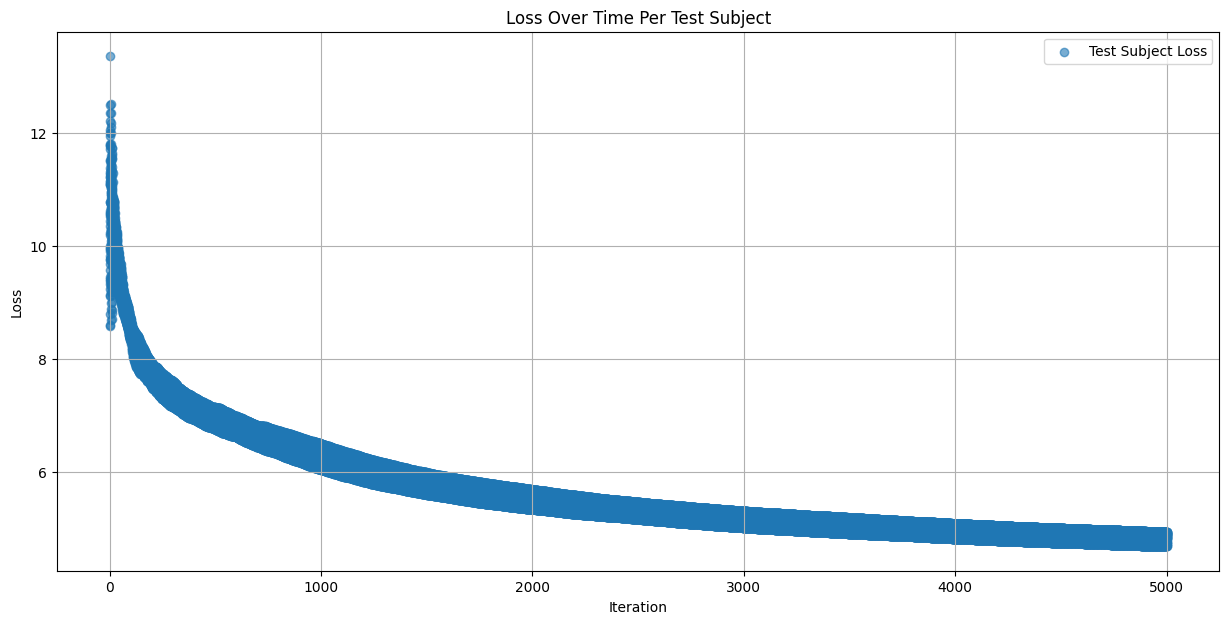

In [ ]:
# Path to .out log file
import re
out_file = "/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/log_outputs/deepmreye_gpu016_9000480_4294967294.out"  
with open(out_file, "r") as f:
    iterations = []
    losses = []

    for line in f:
        match = re.search(r"(\d+)/5000 .*? loss: ([\d\.]+)", line)
        if match:
            iterations.append(int(match.group(1)))
            losses.append(float(match.group(2)))

    # Plot the loss over iterations
    plt.figure(figsize=(15, 7))
    plt.scatter(iterations, losses, label="Test Subject Loss", alpha=0.6)  # Use scatter instead of plot
    plt.plot(iterations, losses, linestyle='-', alpha=0.0)  # Keep a light line for trend visibility
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss Over Time Per Test Subject")
    plt.legend()
    plt.grid(True)
    plt.show()


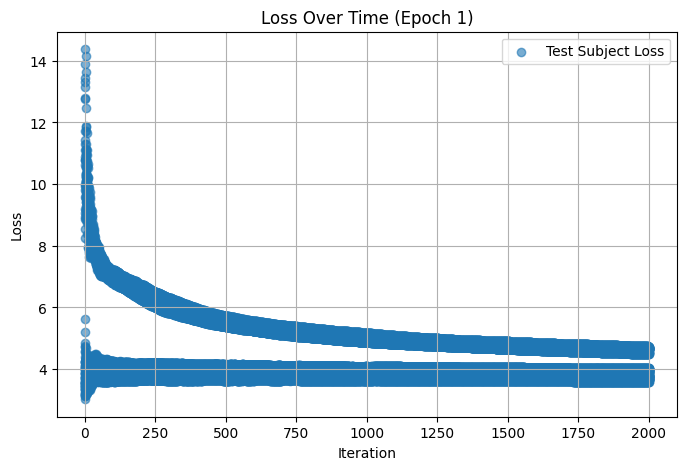

In [47]:
import re
out_file_params2 = "/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/log_outputs/deepmreye_gpu017_9009904_4294967294.out"  
with open(out_file_params2, "r") as f2:
    iterations = []
    losses = []

    # Flag to track when we reach Epoch 3
    epoch_3_found = False
    iterations = []
    losses = []

    for line in f2:
        if "Epoch 1/3" in line:
            epoch_3_found = True
            continue  # Skip to the next line to start collecting loss data
        
        if epoch_3_found:
            match = re.search(r"(\d+)/2000 .*? loss: ([\d\.]+)", line)
            if match:
                iterations.append(int(match.group(1)))
                losses.append(float(match.group(2)))

    # Plot the loss over iterations for Epoch 3
    plt.figure(figsize=(8, 5))
    plt.scatter(iterations, losses, label="Test Subject Loss", alpha=0.6)  # Use scatter instead of plot
    plt.plot(iterations, losses, linestyle='-', alpha=0.0)  # Keep a light line for trend visibility
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss Over Time (Epoch 1)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [37]:
# Extract val_loss per epoch
# Dictionary to store val_loss per subject per epoch
val_losses = defaultdict(lambda: {})

epoch = None
subject = None

out_file_params2 = "/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/log_outputs/deepmreye_gpu017_9009904_4294967294.out"  
with open(out_file_params2, "r") as f2:
    for line in f2:
        # Detect subject from file path
        subject_match = re.search(r"sub-(\d+)_DeepMReyeCalib_label_params2\.npz", line)
        epoch_match = re.search(r"Epoch (\d+)/\d+", line)
        val_loss_match = re.search(r"val_loss: ([\d\.]+)", line)

        if subject_match:
            subject = int(subject_match.group(1))  # Extract subject number

        if epoch_match:
            epoch = int(epoch_match.group(1))  # Extract epoch number

        if val_loss_match and epoch is not None and subject is not None:
            val_losses[subject][epoch] = float(val_loss_match.group(1))

    # Print extracted val_loss values per subject
    for sub, epochs in val_losses.items():
        for ep, val_loss in epochs.items():
            print(f"Subject {sub}, Epoch {ep}: val_loss = {val_loss}")

Subject 8, Epoch 1: val_loss = 5.5991
Subject 8, Epoch 2: val_loss = 8.1887
Subject 8, Epoch 3: val_loss = 6.1331
Subject 11, Epoch 1: val_loss = 6.3335
Subject 11, Epoch 2: val_loss = 4.1641
Subject 11, Epoch 3: val_loss = 4.6435
Subject 7, Epoch 1: val_loss = 4.9676
Subject 7, Epoch 2: val_loss = 4.2298
Subject 7, Epoch 3: val_loss = 4.5536
Subject 9, Epoch 1: val_loss = 2.7305
Subject 9, Epoch 2: val_loss = 3.3673
Subject 9, Epoch 3: val_loss = 3.3961
Subject 3, Epoch 1: val_loss = 4.0158
Subject 3, Epoch 2: val_loss = 4.143
Subject 3, Epoch 3: val_loss = 3.1048
Subject 14, Epoch 1: val_loss = 4.8665
Subject 14, Epoch 2: val_loss = 4.6886
Subject 14, Epoch 3: val_loss = 4.0331
Subject 2, Epoch 1: val_loss = 5.1201
Subject 2, Epoch 2: val_loss = 5.52
Subject 2, Epoch 3: val_loss = 5.9131
Subject 10, Epoch 1: val_loss = 3.5826
Subject 10, Epoch 2: val_loss = 4.9859
Subject 10, Epoch 3: val_loss = 4.3719
Subject 15, Epoch 1: val_loss = 2.7877
Subject 15, Epoch 2: val_loss = 3.4065
Subj

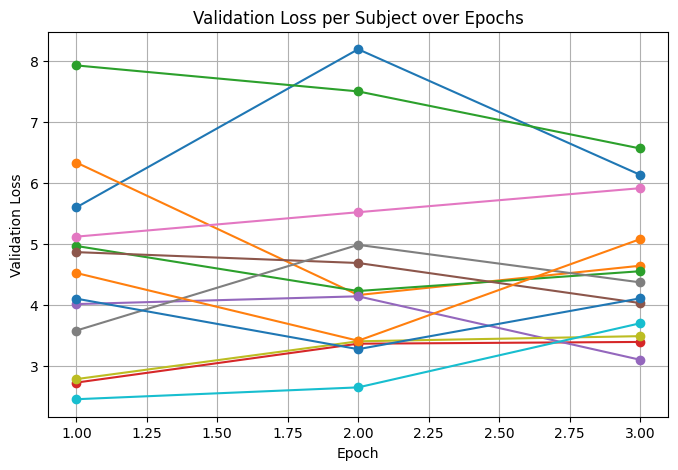

In [29]:
# Plot val_loss per subject over epochs
plt.figure(figsize=(8, 5))

for subject, epochs in val_losses.items():
    sorted_epochs = sorted(epochs.keys())  # Ensure epochs are in order
    losses = [epochs[ep] for ep in sorted_epochs]
    
    plt.plot(sorted_epochs, losses, marker='o', linestyle='-', label=f"Subject {subject}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Subject over Epochs")
plt.grid(True)
plt.show()

Subject 2, val_loss = 5.6215
Subject 5, val_loss = 7.3394
Subject 6, val_loss = 2.3369
Subject 11, val_loss = 3.7684
Subject 3, val_loss = 3.5058
Subject 8, val_loss = 4.3589
Subject 9, val_loss = 3.2069
Subject 13, val_loss = 3.6228
Subject 10, val_loss = 3.117
Subject 7, val_loss = 3.0317
Subject 4, val_loss = 4.7868
Subject 14, val_loss = 4.0658
Subject 15, val_loss = 4.1856


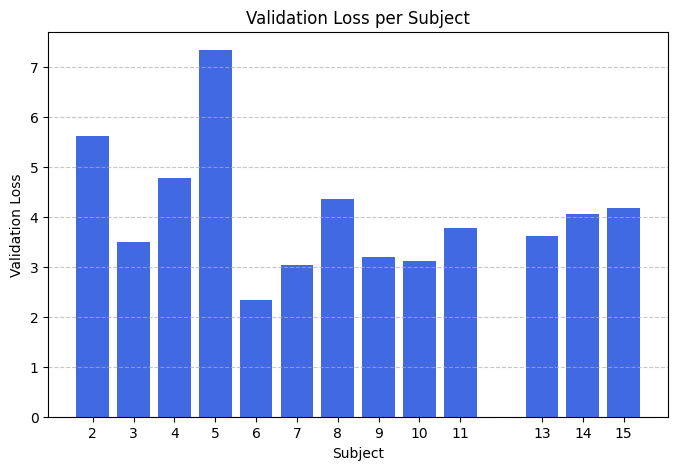

In [34]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

# Dictionary to store val_loss per subject
val_losses_no_epochs = {}

subject = None

out_file = "/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/log_outputs/deepmreye_gpu016_9000480_4294967294.out"

with open(out_file, "r") as f:
    for line in f:
        # Detect subject from file path
        subject_match = re.search(r"sub-(\d+)_DeepMReyeCalib_label_no_interpol\.npz", line)
        val_loss_match = re.search(r"val_loss: ([\d\.]+)", line)

        if subject_match:
            subject = int(subject_match.group(1))  # Extract subject number

        if val_loss_match and subject is not None:
            val_losses_no_epochs[subject] = float(val_loss_match.group(1))  # Store latest val_loss per subject

# Print extracted val_loss values per subject
for sub, val_loss in val_losses_no_epochs.items():
    print(f"Subject {sub}, val_loss = {val_loss}")

# Plot val_loss per subject
plt.figure(figsize=(8, 5))
plt.bar(val_losses_no_epochs.keys(), val_losses_no_epochs.values(), color='royalblue')

plt.xlabel("Subject")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Subject")
plt.xticks(list(val_losses_no_epochs.keys()))  # Ensure proper subject labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


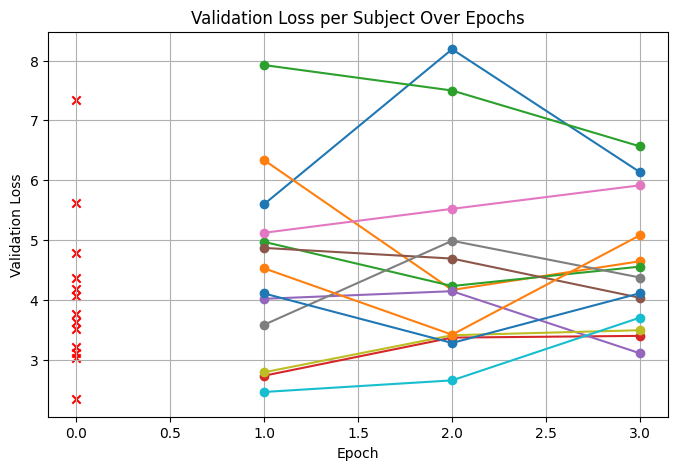

In [40]:
# Plot val_loss per subject over epochs
plt.figure(figsize=(8, 5))

# Plot val_loss over epochs for each subject
for subject, epochs in val_losses.items():
    sorted_epochs = sorted(epochs.keys())  # Ensure epochs are in order
    losses = [epochs[ep] for ep in sorted_epochs]
    
    plt.plot(sorted_epochs, losses, marker='o', linestyle='-', label=f"Subject {subject}")

# Plot the latest val_loss from the new model as scatter points
for subject, val_loss in val_losses_no_epochs.items():
    plt.scatter(min(sorted_epochs) - 1, val_loss, color='red', label=f"Final val_loss Subject {subject}", marker='x')

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Subject Over Epochs")

plt.grid(True)
plt.show()


In [43]:
scores_ft = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/scores_dict_calib_no_interpol.npy", allow_pickle=True).item()

print(scores_ft['/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_interpol/sub-02_DeepMReyeCalib_label_no_interpol.npz'])

scores_ft2 = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/scores_dict_calib_params2.npy", allow_pickle=True).item()

print(scores_ft2['/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_params2/sub-02_DeepMReyeCalib_label_params2.npz'])

                Pearson                     R^2-Score                      \
                      X         Y      Mean         X         Y      Mean   
Default        0.833437  0.851901  0.842669  0.657458  0.556142  0.606800   
Default subTR  0.765944  0.760985  0.763465  0.548677  0.436582  0.492630   
Refined        0.860156  0.853646  0.856901  0.648598  0.544957  0.596778   
Refined subTR  0.810594  0.799007  0.804801  0.581870  0.472312  0.527091   

              Eucl. Error                      
                     Mean    Median       Std  
Default          3.883369  3.661222  1.872352  
Default subTR    4.417745  4.000506  2.428888  
Refined          3.763060  3.545630  1.810800  
Refined subTR    4.119290  3.805758  2.150275  
                Pearson                     R^2-Score                      \
                      X         Y      Mean         X         Y      Mean   
Default        0.821072  0.864025  0.842548  0.641712  0.510248  0.575980   
Default subTR  0.7

In [ ]:
index = ["Default", "Default subTR", "Refined", "Refined subTR"]
df = pd.DataFrame(data, index=index)

# Separate into Default and Refined for comparison
default = df.loc["Default"]
refined = df.loc["Refined"]

# Compute percentage improvement of Refined over Default
improvement = (refined - default) / default * 100

# Print improvement table
print("Performance Improvement (%) - Refined vs. Default")
print(improvement)

# Plot performance comparisons
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Pearson Correlation
axes[0].bar(["X", "Y", "Mean"], default["Pearson"], label="Default", alpha=0.7)
axes[0].bar(["X", "Y", "Mean"], refined["Pearson"], label="Refined", alpha=0.7)
axes[0].set_title("Pearson Correlation")
axes[0].legend()

# R^2 Score
axes[1].bar(["X", "Y", "Mean"], default["R^2-Score"], label="Default", alpha=0.7)
axes[1].bar(["X", "Y", "Mean"], refined["R^2-Score"], label="Refined", alpha=0.7)
axes[1].set_title("R^2 Score")

# Euclidean Error (lower is better)
axes[2].bar(["Mean", "Median", "Std"], default["Eucl. Error"], label="Default", alpha=0.7)
axes[2].bar(["Mean", "Median", "Std"], refined["Eucl. Error"], label="Refined", alpha=0.7)
axes[2].set_title("Euclidean Error (Lower is Better)")

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()